# Libraries

In [1]:
import numpy as np ###v1.20.3
import astropy###v4.3.1
from astropy.io import fits
import matplotlib.pyplot as plt###v3.4.3
import cv2 #!pip3 install opencv-python ###v4.5.5
from scipy import signal ### v1.7.1
import scipy
from scipy.signal import chirp, find_peaks, peak_widths
from astropy.io import fits

from PIL import Image###v8.4.0
from skimage import io, color###V0.18.3
import math
import statistics
import pandas as pd



import matplotlib.pyplot as plt
from matplotlib import rcParams
# for pretty plotting
rcParams['font.size']=14
rcParams['text.usetex']=True
rcParams['pgf.texsystem']='pdflatex'
rcParams['font.family']='DejaVu Sans'
rcParams['font.serif']='cm'
rcParams['text.latex.preamble']=r'\usepackage[T2A]{fontenc}'

# Functions

In [2]:
def subimage_preob(data, x1,y1,x2,y2,x3,y3,x4,y4): #calib, center, theta, width, height):
    ''' 
    Rotates OpenCV image around center with angle theta (in deg)
    then crops the image according to width and height.
    '''
    tan = (y2-y1)/(x2-x1)
    radian = math.atan2((y1-y2),(x1-x2))
    theta = radian*180/np.pi
    if theta > 90:
        theta = -180 + theta
    elif theta < -90:
        theta = 180 + theta
    else:
        theta = theta
    print(theta)
    
    polygon_data = ((x1,y1), (x2, y2), (x3, y3), (x4, y4)) 
    center = centroid(polygon_data) #обращается к фукции centroid
    
    shape = (data.shape[1],data.shape[0])
    matrix = cv2.getRotationMatrix2D( center=center, angle=theta, scale=1 ) #поворот матрицы вокруг указанного центра
    data_rotated = cv2.warpAffine(src=data, M=matrix, dsize=shape ) #сохранение повернутого изображения из матриц
    
    width = ((x1-x2)**2+(y1-y2)**2)**0.5
    height = ((x1-x4)**2+(y1-y4)**2)**0.5
    
    
    x = int( center[0] - width/2  ) #поиск координаты x слева
    y = int( center[1] - height/2 ) # поиск координаты у снизу

    data_croped = data_rotated[ y:int(y+height), x:int(x+width) ] #обрезка изображения по координатам
    
    #preob
    array_log10 = np.log10(65535/data_croped)*1000 
    mean = array_log10.mean(axis=0) #среднее значение по столбцам
    
    plt.imshow(data_croped) #path -- путь к корневой дирректории
    #возвращает обрезанное изображение

    return data_croped

def line_rotate(data, k, b): #calib, center, theta, width, height):
    ''' 
    Rotates OpenCV image around center with angle theta (in deg)
    then crops the image according to width and height.
    '''
    x1 = 0
    x2=len(data[0])
    y1 = k*x1+b
    y2 = k*x2+b
    tan = (y2-y1)/(x2-x1)
    radian = math.atan2((y1-y2),(x1-x2))
    theta = radian*180/np.pi
    if theta > 90:
        theta = -180 + theta
    elif theta < -90:
        theta = 180 + theta
    else:
        theta = theta
    print(theta)

    
    shape = (data.shape[1],data.shape[0])
    matrix = cv2.getRotationMatrix2D( center=(x2/2,y2/2), angle=theta, scale=1 ) #поворот матрицы вокруг указанного центра
    data_rotated = cv2.warpAffine(src=data, M=matrix, dsize=shape ) #сохранение повернутого изображения из матриц
    
 
    plt.imshow(data_rotated) #path -- путь к корневой дирректории
    #возвращает обрезанное изображение
    return data_rotated

def data_crop(data,x1,x2,y1,y2): 
    return data[ y1:y2, x1:x2] 


def centroid(vertexes):
    x_list = [vertex[0] for vertex in vertexes]
    y_list = [vertex[1] for vertex in vertexes]
    lenth = len(vertexes)
    x = sum(x_list) / lenth
    y = sum(y_list) / lenth
    return(x, y)

def peaks_our(mean):    
    
    for ind,p in enumerate(mean): 
        
        if p < mean[ind+1]:
            continue
        
        else:
            first_peak_ind = ind 
            break

    random_peak_ind=[first_peak_ind]
    
    for ind in range(first_peak_ind+1,len(mean)-1):
        
        if mean[ind] > mean[ind-1] and mean[ind] > mean[ind+1]:
            random_peak_ind.append(ind)
            
    bad_peaks = []
    good_peaks = []
    min_dist = 10
    counter = 0
    
    for ind in range(0,len(random_peak_ind)-1):
        delta = random_peak_ind[ind+1] - random_peak_ind[ind]
        
        if delta < min_dist:
            bad_peaks.append(random_peak_ind[ind])
            bad_peaks.append(random_peak_ind[ind+1])
        
        else:
            
            if len(bad_peaks)==0:
                good_peaks.append(random_peak_ind[ind])
            
            else:
                bad_peaks = np.array(np.unique(bad_peaks))
                mean_index = int(bad_peaks.mean())
                good_peaks.append(mean_index)
                bad_peaks = []

    good_peaks.append(random_peak_ind[-1])
    
    if len(good_peaks) > 9:
        
        if mean[[good_peaks[-1]]] < mean[[good_peaks[-2]]]:
            good_peaks = good_peaks[:-1] 
            
    peak_mean =[] # создаем пустой массив для средних значений пиков
    for i in range(0,len(mean)):
        if i in good_peaks:
            peak_mean.append((mean[i-2]+mean[i-1]+mean[i]+mean[i+1]+mean[i+2])/5) # ищем среднее по пяти рядом стоящих значений
    #возвращает позицию/индекс найденного пика и среднее значение по пяти значениям : пик + 2 слева + 2 справа        

    return good_peaks, peak_mean                    

In [3]:
def aprx1(x,y,order):
    
    """
    DOUBLE APPROXIMATION
    """

    monotone = False
    while monotone == False:
        
        z = np.polyfit( x,y,order)
        p = np.poly1d(z)
        xp = np.linspace(0, x[-1],1000) #1000
        # print(xp)
        pxp = p(xp)

        for i in range(1,len(pxp)):
            max_pxp = y[:-1].max()
            if pxp[i]<=pxp[i-1]:
                pxp[i]=pxp[i-1]+1
                if pxp[i]>=max_pxp:
                    min_pxp = pxp[i-100]
                    delta_pxp = abs((max_pxp - min_pxp)/(len(pxp)-i-1))
                    index = i-10
                    break


        for j in range(index+1,len(pxp)):
            pxp[j]=pxp[j-1]+delta_pxp

        z = np.polyfit( xp,pxp, 6)
        pp = np.poly1d(z)
        xpp = np.linspace(0, x[-1], 1000)#1000

        pxpp = pp(xpp)
        
        check = []
        for k in range(0,len(pxpp)-1):      
            if pxpp[k]>pxpp[k+1]:
                check.append(k)
        
        if len(check) == 0:
                monotone = True
        else:
            order = order+1
            monotone = False
               
    fig, ax1 = plt.subplots(figsize=(8,5),dpi=80)
    ax1 = plt.scatter(x[:-1],y[:-1], color="blue",s=5) 
    ax1 = plt.plot(xp[:4200], p(xp[:4200]), color="orange")           

    fig, ax2 = plt.subplots(figsize=(6,4),dpi=120)
    ax2 = plt.plot( xpp[:4200], pp(xpp[:4200]), lw=1, label = f"Апроксимация полиномом ({order},6)")#"Polynomial approximation")
    ax2 = plt.scatter(x[:-1],y[:-1], color="red",s=50,marker='.')#, label = "Attenuator magnitude")
    # ax2.
    plt.legend()
    
    plt.xlabel("Интенсивность")
    plt.ylabel("Почернение")
#     plt.yticks([200, 300, 400, 500, 600, 700, 800, 900])
#     plt.savefig("characteristic_curve.jpg")
    return xpp,pp

In [40]:
def aprx2(x,y,order):

    """
    MONO APPROXIMATION
    """
        
    z = np.polyfit( x,y,order)
    p = np.poly1d(z)
    xp = np.linspace(x[0], x[-1], 3000)
    # print(xp)
    pxp = p(xp)

    for i in range(1,len(pxp)):
        max_pxp = y[:-1].max()
        if pxp[i]<=pxp[i-1]:
            pxp[i]=pxp[i-1]+1
            if pxp[i]>=max_pxp:
                min_pxp = pxp[i-100]
                delta_pxp = abs((max_pxp - min_pxp)/(len(pxp)-i-1))
                index = i-10
                break


    for j in range(index+1,len(pxp)):
        pxp[j]=pxp[j-1]+delta_pxp
               
    fig, ax1 = plt.subplots(figsize=(6,4),dpi=120)
    ax1 = plt.scatter(x,y, color="blue",s=50,label=f"Разница длин волн") 
    ax1 = plt.plot(xp, p(xp), color="orange",lw=2,label=f"Полином ({order})")   
    plt.legend()
    plt.xlabel("Номер столбца пикселей")
    plt.ylabel("$\Delta \lambda$")
    
    return xp,p



def mean_deviation(x_array,y_array):

    c = []
    for i in range(1,len(y_array)):
        c.append(abs(y_array[i] - y_array[i-1]))
    mean_deviation = np.array(c).sum()/len(y_array)

    #now we sort our data: if delta between neighboring elements larger than 2 mean deveation we will remove it
    indexes = []
    for i in range(1,len(y_array)):
        if abs(y_array[i]-y_array[i-1])>mean_deviation*2:
            indexes.append(i)

    y_array = np.delete(y_array,indexes)
    x_array = np.delete(x_array,indexes)
    xarray_flux = 10000/10**(x_array/2.5)
    a = []
    for i in range(0,len(xarray_flux)):
        a.append([xarray_flux[i],y_array[i]])

    a.sort(key=lambda x:x[0])

    xarray_flux = []
    y_array = []

    for i in range(0,len(a)):
        xarray_flux.append(a[i][0])
        y_array.append(a[i][1])

    xarray_flux = np.array(xarray_flux)
    y_array = np.array(y_array)       
    del a
    
    plt.figure(figsize=(6,4),dpi=150)
    plt.plot(xarray_flux, y_array, markersize=3,marker='o' )
    plt.grid(lw=0.2)
    plt.xlabel("Интенсивность")
    plt.ylabel("Оптическая плотность")
    
    return xarray_flux, y_array

def rounding(value):
    """
    Rounds values taking into accaunt fraction part
    
    value -- float number 
    
    Example:
    3.1 -> 3
    3.6 -> 4
    """
    try:
        value = float(value)
    except ValueError:
        print("Input should be a digit or a float!")
    
    if value > 0:
        sign = 1
    else:
        sign = -1
        
    value = abs(value)
    
    frac = value - int(value)
    
    if frac >= 0.5:
        return math.ceil(value)*sign
    else:
        return math.floor(value)*sign
        

def moving_average(n_points, array):
    """
    RETURNS "BLURED" ARRAY
    
    n_points -- number of points for moving average
    array - usually y array
    """
    # выберем кол-во точек для скользящего среднего
    n_points = 10
    
    # создаем функцию окна
    W = np.zeros_like(array); W[0:n_points]=1
    
    FConv = np.fft.fft(array)*np.fft.fft(W)
    
    TConv = np.fft.ifft(FConv).real/n_points
    
    # отбрасываем те точки, где скользящее среднее неадекватно срабатывает 
    # то есть первые и последние N_rm/2 точек
    
    Nskip = int((n_points-1)/2) 
    return np.pad(TConv[Nskip:],(0,Nskip),'constant')

def preob_spectra(spectra):
    
    """
    Функция пересчитывает плотности почернения в интенсивности при помощи полинома, полученного 
    в работе с калибровками.
    На выходе преобразованный спектр и график, из которого необходимо определить на каких строках (х1 и х1) находится спектр.
    Тут же можно определить где находятся лампы.
    """
    x_log = (np.log10(65535/spectra) * 1000)
#     spectra_ = (2.803e-20*x_log**6 - 5.835e-16*x_log**5 + 1.635e-12*x_log**4 + 4.247e-08*x_log**3 - 0.0004067*x_log**2 + 1.439*x_log + 196.7).sum()
    
#     spectra_ = polinomial(x_log)
#     sum_intens_row = spectra_.sum(axis=1)
    sum_intens_row = x_log.sum(axis=1)
    
#     plt.figure(figsize=(6,4),dpi=120)
#     plt.plot(sum_intens_row)
#     plt.grid(lw=0.1)
#     plt.xlabel("Номер строки пикселей")
#     plt.ylabel("Сумма интенсивностей")
#     plt.savefig("spectra_background_row1972s.jpeg")
    return  x_log,sum_intens_row#spectra_

def spectra_lamps(data,y1,y2,y3,y4,y5,y6):
    
    """
    Функция для вырезания из целого изображения спектра двух ламп и
    спектра самого объекта по отдельнсти.
    """
    
    lamp_1 = data[y1:y2]
    spectra = data[y3:y4]
    lamp_2 = data[y5:y6]
    
    
    fig, ax1 = plt.subplots(figsize=(10,8),dpi=120)
    ax1.imshow(lamp_1)
    ax1.set_title("lamp1")
    
    
    fig, ax2 = plt.subplots(figsize=(10,8),dpi=120)
    ax2.imshow(spectra)
    ax2.set_title("spectra")

    fig, ax3 = plt.subplots(figsize=(10,8),dpi=120)
    ax3.imshow(lamp_2)
    ax3.set_title("lamp2")

    
    fig, ax4 = plt.subplots(figsize=(10,8),dpi=120)
    ax4.imshow(data)
    ax4.set_title("data")
    ax4.axhline(y1,c="r",lw=1)
    ax4.axhline(y2,c="r",lw=1)
    ax4.axhline(y3,c="b",lw=1)
    ax4.axhline(y4,c="b",lw=1)
    ax4.axhline(y5,c="r",lw=1)
    ax4.axhline(y6,c="r",lw=1)
    
    return lamp_1, spectra, lamp_2

def spectra_background(data,x1,x2):
    
    """
    Разбивает часть изображения со спектром на фон (над и под) и спектр.
    Вычитает фон из спектра и 
    на выходе выдает ГОТОВЫЙ спектр (+график, конечно же)
    """
    print("SPECTRA BACK BEFORE ",data.dtype)
    back_1 = data[0:x1]
    back_2 = data[x2:]
    back = np.concatenate((back_1,back_2))
    back_mean = back.mean(axis=0)
    
    spectrum = data[x1:x2]
    spectrum_sum = np.array(spectrum).sum(axis=0)
    spectrum_final = spectrum_sum - back_mean*(x2-x1)
    
    print("SPECTRA BACK AFTER ",spectrum_final.dtype)
    plt.figure(figsize=(8,4),dpi=120)
    plt.plot(spectrum_final)
    plt.xlabel("Номер столбца пикселей")
    plt.ylabel("Интенсивность")
    return spectrum_final

def standart_deviation(list_value):
    mean = np.mean(list_value)
    summ = []
    for i in list_value:
        summ.append((i-mean)**2)
    std = np.sqrt(np.sum(summ)/len(list_value))
    return std

def x_axis_to_wavelenght(lamp_1,lamp_2):
    
    lamp_1_std = standart_deviation(lamp_1)*0.5
    
    index_l_1 = []
    
    for i in range(1,len(lamp_1)-1):
        if lamp_1[i] > lamp_1_std and lamp_1[i] > lamp_1[i+1] and lamp_1[i] > lamp_1[i-1]:
            index_l_1.append(i)
     
    dalta_ind_l1 = []
    for i in range(1,len(index_l_1)):
        dalta_ind_l1.append(index_l_1[i]-index_l_1[i-1])
    delta_std_l1 = standart_deviation(dalta_ind_l1)
    
    index_l1 = []
    counter_l1 = 0 
    for i in range(0,len(index_l_1)):
            
            if counter_l1 == 0:
                index_l1.append(index_l_1[i])
                countr_l1 =+ 1
           
            else:
                d = index_l_1[i] - index_l_1[i-1]
                countr_l1 =+ 1
                if d < delta_std_l1:
                    index_l1.append(index_l_1[i])  
    
    
    index_l1_1 = index_l1[0]
    index_l1_2 = index_l1[-1]
    
    lamp_2_std = standart_deviation(lamp_2)*0.5
    
    index_l_2 = []
    for i in range(1,len(lamp_2)-1):
        if lamp_2[i] > lamp_2_std and lamp_2[i] > lamp_2[i+1] and lamp_2[i] > lamp_2[i-1]:
            index_l_2.append(i)
            
        
    dalta_ind_l2 = []
    for i in range(1,len(index_l_2)):
        dalta_ind_l2.append(index_l_2[i]-index_l_2[i-1])
    delta_std_l2 = standart_deviation(dalta_ind_l2)
    
    index_l2 = []
    counter_l2 = 0 
    for i in range(0,len(index_l_2)):
            
            if counter_l2 == 0:
                index_l2.append(index_l_2[i])
                countr_l2 =+ 1
           
            else:
                d = index_l_2[i] - index_l_2[i-1]
                countr_l2 =+ 1
                if d < delta_std_l2:
                    index_l2.append(index_l_2[i])          
            
            
    index_l2_1 = index_l2[1]
    index_l2_2 = index_l2[-1]
    
    index_1 = int(np.mean([index_l1_1,index_l2_1]))
    index_2 = int(np.mean([index_l1_2,index_l2_2]))
    

    #PLOT
    fig, ax1 = plt.subplots(figsize=(8,4),dpi=150)
    ax1.plot(lamp_1,label="Спектр лампы")
    ax1.axhline(lamp_1_std,c="gray",lw=1,label="Стандартное отклонение")
    ax1.axvline(index_l1_1,c="orange",lw=1,label="Первая линия")
    ax1.axvline(index_l1_2,c="r",lw=1,label="Последняя линия")
    ax1.scatter(index_l1, lamp_1[index_l1],c="g",label="Эмиссионные линии")
    ax1.legend(bbox_to_anchor=(0.97,-0.15),ncols=2)
    ax1.set_xlabel("Номер столбца пикселей")
    ax1.set_ylabel("Интенсивность")
    fig, ax2 = plt.subplots(figsize=(8,4),dpi=150)
    ax2.plot(lamp_2,label="Спектр лампы")
    ax2.axhline(lamp_2_std,c="gray",lw=1,label="Стандартное отклонение")
    ax2.axvline(index_l2_1,c="orange",lw=1,label="Первая линия")
    ax2.axvline(index_l2_2,c="r",lw=1,label="Последняя линия")      
    ax2.scatter(index_l2, lamp_2[index_l2],c="g",label="Эмиссионные линии")
    ax2.legend(bbox_to_anchor=(0.97,-0.15),ncols=2)
    ax2.set_xlabel("Номер столбца пикселей")
    ax2.set_ylabel("Интенсивность")
    
    return index_1,index_2, index_l1,index_l2

def pixel2wavelenght(spectra,lambd_0,lambd_n,N_0,N_n):
    
    """
    Function calculates mean dispersion of wavelenghts
    and convert numbers of columns to wavelenght using lamp spectra.
    
    spectra -- final spectra of object/lamp without background (1-d array)
    lambd_0 -- the wavelengths of the first line of lamp spectra in angstroms 
    lambd_n -- the wavelengths of the last line of lamp spectra in angstroms
    N_0 -- column number of the first line
    N_n -- column number of the last line
    """
    dispersion = (lambd_n - lambd_0)/(N_n - N_0)
    wavelenght = []
    
    for i in range(0,len(spectra)):
        delta = i - N_0
        wl = delta * dispersion #distance in angstrom between a column and first line column
        wavelenght.append(lambd_0+wl)
        
        #PLOT
    plt.figure(figsize=(18,9))
    plt.plot(wavelenght,spectra)
    
    return wavelenght,dispersion

def func(index_1,index_2,x1,x2,x3,x4,x5,lambd_1,lambd_2,lambd_3,lambd_4,lambd_5,wavelenght):
    
    delta_lambd_1 = wavelenght[x1] - lambd_1 
    delta_lambd_2 = wavelenght[x2] - lambd_2 
    delta_lambd_3 = wavelenght[x3] - lambd_3 
    delta_lambd_4 = wavelenght[x4] - lambd_4 
    delta_lambd_5 = wavelenght[x5] - lambd_5 
    
    corr = np.array([0,delta_lambd_1,delta_lambd_2,delta_lambd_3,delta_lambd_4,delta_lambd_5,0]) #0 in the begging and in the end because we exactly know wavelenght of index_1,index_2
    
    plt.figure(figsize=(6,4), dpi=120)
    plt.scatter([index_1,x1,x2,x3,x4,x5,index_2],corr,s=50)
    plt.xlabel("Номер столбца пикселей")
    plt.ylabel("$\Delta \lambda$")
    xpp, polinomial = aprx2([index_1,x1,x2,x3,x4,x5,index_2],corr,5)
    
    columns = np.arange(0,len(wavelenght))
    
    correction_whole = np.array(polinomial(columns))
    
    wavelenght_corrected = wavelenght + correction_whole
    
    return wavelenght_corrected,polinomial

def graf(data, order):
    fig = plt.figure(figsize=(8,5),dpi = 100)
    ax1 = fig.add_subplot(2,1,1)
    x = np.arange(1, len(data) + 1)
    ax1.scatter(x,data,color = 'orangered', s = 2, alpha = 0.5)
    ax1.set_xlabel("Pixel")
    ax1.set_ylabel("Value of pixel")

    peak_indexes,peak_mean = peaks(data,order=order) #func_peaks
    ax2 = fig.add_subplot(2,1,2)
    x1 = np.arange(0,len(data))
    ax2.plot(x1,data)
    ax2.scatter(peak_indexes, data[[peak_indexes]], color = 'y', s = 10, marker = 'D', label = 'maxima')
    ax2.scatter(peak_indexes, peak_mean, color = 'r', s = 10, marker = 'D', label = 'maxima')
    ax2.set_xlabel("Pixel")
    ax2.set_ylabel("Value of pixel")
    
    return peak_indexes,peak_mean


def polynomial_alighn(data,order):
    
    """
    function aligns the spectrum through finding min value in each column and approximate it with polynomial and mean for polinomial line
    
    data - whole image
    up_limit,low_limit - limits of spectra in rows number
    order - polinomial order to approximate spectra
    
    """
    
    #_____________________cut_________________________________
    print("DATA AFTER MANAS PROG ", data.dtype)
    x_log1,sum_intens_row1 = preob_spectra(data)  # смотри на боковую проекцию всего кадра (кривой)  
    x1 = sum_intens_row1
    peaks1, _ = find_peaks(x1,distance = len(x1)*0.3)
    results_full1 = peak_widths(x1, peaks1, rel_height=0.9)
    print(results_full1)
    data_part1 = data[int(results_full1[-2][0]*1.10):int(results_full1[-2][1]*0.90)]
    
    fig,ax1 = plt.subplots(figsize=(8,5),dpi=150)
    ax1.plot(sum_intens_row1)
    ax1.set_xlabel("Номер строки пикселей")
    ax1.set_ylabel("Оптическая плотность")
    #ax1.set_title("ax1")
    
    fig, ax2 = plt.subplots(figsize=(8,5), dpi=150)
    ax2.imshow(data_part1, cmap='gray')
    ax2.set_title("ax2")
    #_____________________align_first______________________________________
    
      #create massive of part of whole spectra with arrays of columns, not rows
    data_columns1 = []
    for i in range(0,len(data_part1[0])):
        data_columns1.append(list(data_part1[:,i]))
    data_columns1=list(data_columns1)
    
    #create massive of whole spectra with arrays of columns, not rows
    data_collumns_entire_image1 = []
    for j in range(0,len(data[0])):
        data_collumns_entire_image1.append(list(data[:,j]))
    data_collumns_entire_image1=list(data_collumns_entire_image1)

    #find min value in each column and then find indexes of the values - they will be Y-coordinate
    data_col_min1 = []
    for i in range(0,len(data_columns1)):
        data_col_min1.append(np.min(data_columns1[i]))
        
    index1 = []
    for i in range(0,len(data_col_min1)):
            index1.append(data_columns1[i].index(data_col_min1[i]))
    #find median value of neighboring indexes of min values in each column in some ranges to compairing in the next steps
    #we schould find mediam values for ranges not for whole image, because we have non-linear graph and it has curvature  
    median1 = []
    n = 0
    while n+100<len(index1):
        k=n+100
        median1.append([n,k,np.median(index1[n:k])])
        n=k
    else:
        median1.append([n,-1,np.median(index1[n:])])

    #calculate mean delta between neighboring values
    delt1=[]
    for i in range(1,len(index1)):
        delt1.append(abs(index1[i]-index1[i-1]))
    delt_mean1 = np.array(delt1).sum()/len(delt1)    

    #now we compair difference between median value indexes of minimum value in each column     
    for i in median1:
        for j in range(i[0],i[1]):
            if abs(i[2]-index1[j])>delt_mean1:
                index1[j] = i[2]

    
    #plot polynomial
    xp1 = np.arange(0,len(index1))
    z1 = np.polyfit(xp1,index1, order)
    polynomial1 = np.poly1d(z1)
    y_polynomial1 = polynomial1(xp1)
    fig, ax3 = plt.subplots(figsize=(8,5), dpi=150)
#     ax3.plot(index1)
    ax3.plot(index1, color="steelblue", label="Спектральная линия") 
    ax3.plot(xp1, y_polynomial1, color="orange", label=f"Полином, порядок = {order}")
#     ax3.set_title("Polinomial approximation of spectra")
    #ax3.set_title("ax3")
    ax3.axhline(y_polynomial1.mean(), color="green", label="Среднее значение \nполинома")
    ax3.legend()
    ax3.set_xlabel("Номер столбца пикселей")
    ax3.set_ylabel("Номер строки пикселей")
    
    xp_tg1 = np.arange(0,len(y_polynomial1))
    z_tg1 = np.polyfit(xp_tg1,y_polynomial1, 1)
    polynomial_tg1 = np.poly1d(z_tg1)
    y_polynomial_tg1 = polynomial_tg1(xp_tg1)
    tg1 = polynomial_tg1[1]
    
    #now we will plot our curve on our frame
    mean_polynomial1 = y_polynomial1.mean()
    fig, ax4 = plt.subplots(figsize=(8,5), dpi=150)
    ax4.imshow(data_part1, cmap='gray')
    ax4.plot(xp1, y_polynomial1, color="orange", label=f"Polinomial, order = {order}")
    ax4.axhline(mean_polynomial1, label="Polinomial mean")
    ax4.set_title("ax4")
    
    delta_y1 = []
    for i in range(0,len(index1)):
        delta1 = mean_polynomial1 - polynomial1(xp1)[i]
        delta_y1.append(rounding(delta1))

    shape1 = np.array(data_collumns_entire_image1).shape
    new_pic_col1 = np.zeros(shape1,dtype="uint16")
    print("ZEROES ",new_pic_col1.dtype)
    for i in range(0,len(data_collumns_entire_image1)):
        for j in range(0,len(data_collumns_entire_image1[i])):
            m  = j + delta_y1[i]
            if m<len(data_collumns_entire_image1[i]):
                new_pic_col1[i][m] = data_collumns_entire_image1[i][j] 
            else:
                m = m - len(data_collumns_entire_image1[i])
                new_pic_col1[i][m] = data_collumns_entire_image1[i][j] 
    data_rows1 = []
    for i in range(0,len(new_pic_col1[0])):
        data_rows1.append(list(new_pic_col1[:,i]))
            
    
    delta_x1 = np.arange(0,len(data_rows1))*tg1
    shape1 = np.array(data_rows1).shape
    new_data_rows1 = np.zeros(shape1,dtype="uint16")
    for i in range(0,len(data_rows1)):
        for j in range(0,len(data_rows1[i])):
            m  = rounding(j + 2*delta_x1[i])
            if m<len(data_rows1[i]):
                new_data_rows1[i][m] = data_rows1[i][j] 
            else:
                m = m - len(data_rows1[i])
                new_data_rows1[i][m] = data_rows1[i][j] 
    
    aligned_image1 = new_data_rows1
    fig, ax5 = plt.subplots(figsize=(8,5), dpi=150)
    ax5.imshow(aligned_image1,cmap="gray")
    #ax5.set_title("ax5")
    

 
    #_____________________cut_second_________________________________
    
    x_log2,sum_intens_row2 = preob_spectra(aligned_image1)    
    x2 = sum_intens_row2
    peaks2, peak_mean2  = peaks(x2,10)   
#     peaks2, _ = find_peaks(x2,distance = len(sum_intens_row2)/2)
    drop_list2=[]
    for i in range(len(peaks2)):
        if peak_mean2[i]<x2.mean():
            drop_list2.append(i)
    peaks2 = np.delete(np.array(peaks2),drop_list2)
    peak_mean2 = np.delete(np.array(peak_mean2),drop_list2)
    peaks2 = [peaks2[0],peaks2[-1]]
    
    results_full2 = peak_widths(x2, peaks2, rel_height=0.95)
#     print('results_full2=',results_full2)
    data_part2 = aligned_image1[int(results_full2[-1][0]):int(results_full2[-2][1])]
    fig, ax6 = plt.subplots(figsize=(8,5), dpi=150)
    ax6.plot(sum_intens_row2,label="Данные кадра")
    #ax6.set_title("ax6")
    ax6.set_xlabel("Номер строки пикселей")
    ax6.set_ylabel("Оптическая плотность")
    ax6.hlines(*results_full2[1:], color="red",label="Ширина пика (0.95)")
    ax6.axvline(int(results_full2[-1][0]),color="green",label="Спектр лампы")
    ax6.axvline(int(results_full2[-1][1]),color="green")
    ax6.axvline(int(results_full2[-2][0]),color="green")
    ax6.axvline(int(results_full2[-2][1]),color="green")
    ax6.legend()
    
#     #_____________________background_detection______________________________________
    
     #find peaks widths for background removing 
    x_log3,spectr = preob_spectra(data_part2)
    x3 = spectr
    peaks3, _ = find_peaks(x3,distance = len(x3))#
    results_full3 = peak_widths(x3, peaks3, rel_height=0.95) # !!!!!!!!!!!!!!!
    print(results_full3)
    fig, ax7 = plt.subplots(figsize=(8,5), dpi=150)
    ax7.plot(spectr) #возможно надо брать уже
    ax7.hlines(*results_full3[1:])
    ax7.set_title("ax7")
    print("DATA PART2 before spectra back ",data_part2.dtype)
#     #_____________________spectra_background(def)_______________________________________________________
    spectrum_final = spectra_background(65535-np.array(data_part2),int(results_full3[-2]),int(results_full3[-1]))
    fig, ax8 = plt.subplots(figsize=(8,5), dpi=150)
    ax8.plot(spectrum_final,label="Спектр объекта") #возможно надо брать уже
    ax8.set_xlabel("Номер столбца пикселей")
    ax8.set_ylabel("Оптическая плотность")
    #ax8.set_title("ax8")
    
    #_____________________find_peaks______________________________________________________
    peak_indexes,peak_mean = peaks(spectrum_final,100)
    sigma_2 = np.std(spectrum_final)*3
    drop_list=[]
    for i in range(len(peak_indexes)):
        if peak_mean[i]<sigma_2:
            drop_list.append(i)
    peak_indexes = np.delete(np.array(peak_indexes),drop_list)
    peak_mean = np.delete(np.array(peak_mean),drop_list)
    #_____________________peak_check______________________________________________________
    
    if len(peak_indexes) == 1:
        ppeak_indexes = [peak_indexes[0]-100,peak_indexes[0]+100]
    ax8.scatter(peak_indexes,peak_mean, c="red",label="Границы области \nэмиссионных линий")
#     print('peak_indexes:', peak_indexes)
    ax8.legend()
#     #_____________________polynomial_1______________________________________________________
    y_poly = y_polynomial1[int(peak_indexes[0])-100:int(peak_indexes[-1])+100]
    xppp = np.arange(int(peak_indexes[0])-100,int(peak_indexes[-1])+100) #1200,2900
    print('len(xppp)=',len(xppp))
    print('len(y_poly)=',len(y_poly))
    zzz = np.polyfit(xppp,y_poly, 1)
    polynomialll = np.poly1d(zzz)
    y_poly00 = polynomialll(xp1)
    degree = np.degrees(np.arctan2(y_poly00[-1]-y_poly00[0],len(y_poly00)))
    fig, ax9 = plt.subplots(figsize=(8,5), dpi=150)
    ax9.plot(index1, color="steelblue", label="Спектр") 
    ax9.plot(xp1, y_polynomial1, color="orange", label=f"Полином, порядок = {order}")
    ax9.plot(xp1, y_poly00, color="green", label="Линия выравнивания")

    ax9.legend()
    ax9.set_xlabel("Номер столбца пикселей")
    ax9.set_ylabel("Номер строки пикселей")
    #ax9.set_title('ax9') 
    
#     #_____________________align______________________________________________________
    
    xpp_tg2 = np.arange(0,len(y_poly00))
    z_tg2 = np.polyfit(xpp_tg2,y_poly00, 1)
    polynomialll_tg = np.poly1d(z_tg2)
    y_polynomialll_tg = polynomialll_tg(xpp_tg2)
    tg2 = polynomialll_tg[1]
    
    #now we will plot our curve on our frame
    mean_polynomial2 = y_poly00 #y_polynomial.mean()
#     fig, ax10 = plt.subplots(figsize=(8,5), dpi=150)
#     ax10.imshow(data_part1, cmap='gray')
#     ax10.plot(xp1, y_polynomial1, color="orange", label=f"Polinomial, order = {order}")
#     ax10.set_title('ax6')

    
    delta_y2 = []
    for i in range(0,len(index1)):
        delta2 = mean_polynomial2[i] - y_polynomial1[i]
        delta_y2.append(int(delta2))

    shape = np.array(data_collumns_entire_image1).shape
    new_pic_col2 = np.zeros(shape,dtype="uint16")
    for i in range(0,len(data_collumns_entire_image1)):
        for j in range(0,len(data_collumns_entire_image1[i])):
            m  = j + delta_y2[i]
            if m<len(data_collumns_entire_image1[i]):
                new_pic_col2[i][m] = data_collumns_entire_image1[i][j] 
            else:
                m = m - len(data_collumns_entire_image1[i])
                new_pic_col2[i][m] = data_collumns_entire_image1[i][j] 
    data_rows2 = []
    for i in range(0,len(new_pic_col2[0])):
        data_rows2.append(list(new_pic_col2[:,i]))
            
    
    delta_x2 = np.arange(0,len(data_rows2))*tg2
    shape = np.array(data_rows2).shape
    new_data_rows2 = np.zeros(shape,dtype="uint16")
    for i in range(0,len(data_rows2)):
        for j in range(0,len(data_rows2[i])):
            m  = int(j + 2*delta_x2[i])
            if m<len(data_rows2[i]):
                new_data_rows2[i][m] = data_rows2[i][j] 
            else:
                m = m - len(data_rows2[i])
                new_data_rows2[i][m] = data_rows2[i][j] 
    
    aligned_image2 = new_data_rows2
    
    fig, ax10 = plt.subplots(figsize=(8,5), dpi=150)
    ax10.imshow(aligned_image2, cmap='gray')
    #ax10.grid()
    #ax10.set_title("ax10")
#     #_____________________rotation______________________________________________________
    
    center = (int(len(aligned_image2[0])),int(len(aligned_image2))) #обращается к фукции centroid
    print("BEFORE CV2 ",aligned_image2.dtype )
    
    shape = (aligned_image2.shape[1],aligned_image2.shape[0])
    #center = (int(shape[0]/2),int(shape[1]/2))
    matrix = cv2.getRotationMatrix2D( center=center, angle=degree, scale=1 ) #поворот матрицы вокруг указанного центра
    data_rotated = cv2.warpAffine(src=aligned_image2, M=matrix, dsize=shape ) #сохранение повернутого изображения из матриц
    fig, ax11 = plt.subplots(figsize=(8,5), dpi=150)
    ax11.imshow(data_rotated, cmap='gray')
    #ax11.grid()
    ax11.set_title("ax11")
   
    for j in range(0,len(data_rotated)):
        if data_rotated[j][0] != 0:
            index_vertical = j
            break
    data_rotated = data_rotated[index_vertical:]
    
    for i in range(len(data_rotated[0])):
        if data_rotated[0][i] == 0:
            index_horizontal = i
            break
    data_rotated = data_rotated[:,:index_horizontal]
    
    fig, ax12 = plt.subplots(figsize=(8,5), dpi=150)
    ax12.imshow(data_rotated, cmap='gray')
    #ax12.grid()
    ax12.set_title("ax12")
                
#     #_____________________header______________________________________________________
    
    
    
    
    
    print("AFTER CV2 ",data_rotated.dtype )
    

    return data_rotated

def calib_preob(data):
    array_log10 = np.log10(65535/data)*1000 
    mean = array_log10.mean(axis=0)
    return mean


def polynomial_aproximation(x,y,order=6):
    
    """
    We get a polynomial.
    Then check if monotone.
    If curve is not monotone we increase order until it get monotone. (think about upper limits)
    At the end we plot a graph.
    """

    monotone = False
    while monotone == False:
        
        z = np.polyfit( x,y,order)
        poly = np.poly1d(z)
        x_poly = np.linspace(x[0], x[-1],100) #for visualization,
        #not future calculations
        y_poly = poly(x_poly)

        check = []
        for k in range(0,len(y_poly)-1):      
            if y_poly[k]>y_poly[k+1]:
                check.append(k)
        
        if len(check) == 0:
                monotone = True
        else:
            order = order+1
            monotone = False
               
    fig, ax1 = plt.subplots(figsize=(8,5),dpi=150)
    ax1 = plt.scatter(x,y, color="blue",s=5,label="Значение ступеней ослабителя") 
    ax1 = plt.plot(x_poly, y_poly, color="orange",label=f"Полином (порядок={order})")           
    plt.legend()
    plt.grid(lw=0.2)
    plt.ylabel("Интенсивность")
    plt.xlabel("Оптическая плотность")
#     plt.xscale("log")
#     plt.yscale("log")
    
#     plt.yticks([200, 300, 400, 500, 600, 700, 800, 900])
#     plt.savefig("characteristic_curve.jpg")
    return poly

In [5]:
mag_before_1972 = [0,0.61,1.1,1.47,1.84,2.25,2.66,3.04,0]
mag_after_1972 = [0,0.5,0.97,1.44,1.93,2.43,2.69,3.04,0]

# SPECTRA REDUCTION

In [6]:
def spectra_background(data,x1,x2):
    
    """
    Разбивает часть изображения со спектром на фон (над и под) и спектр.
    Вычитает фон из спектра и 
    на выходе выдает ГОТОВЫЙ спектр (+график, конечно же)
    """
    
    back_1 = data[0:x1]
    back_2 = data[x2:]
    back = np.concatenate((back_1,back_2))
    back_mean = back.mean(axis=0)
    
    spectrum = data[x1:x2]
    spectrum_sum = np.array(spectrum).sum(axis=0)
    spectrum_final = spectrum_sum - back_mean*(x2-x1)
    
    plt.figure(figsize=(8,4),dpi=120)
    plt.plot(spectrum_final)
    plt.xlabel("Номер столбца пикселей")
    plt.ylabel("Интенсивность")
#     plt.savefig("spectra_obj_back.jpg")
    
    return spectrum_final

# calibration spectra

In [7]:
def peaks(mean,order):
    """
    function for searching peaks in array 
    """
    peak_indexes = signal.argrelextrema(mean, np.greater, order=order)[0] #индексы пиков 
    peak_mean =[] # создаем пустой массив для средних значений пиков
    for i in range(0,len(mean)-2):
        if i in peak_indexes:
            peak_mean.append((mean[i-2]+mean[i-1]+mean[i]+mean[i+1]+mean[i+2])/5) # ищем среднее по пяти рядом стоящих значений
    #возвращает позицию/индекс найденного пика и среднее значение по пяти значениям : пик + 2 слева + 2 справа
    delta = len(peak_indexes) - len(peak_mean)
    if delta !=0:
        return peak_indexes[:-abs(delta)],peak_mean
    else:
        return peak_indexes,peak_mean

def graf(data, order):
    fig = plt.figure(figsize=(8,6),dpi = 300)
    #ax1 = fig.add_subplot(2,1,1)
    #x = np.arange(1, len(data) + 1)
    #ax1.scatter(x,data,color = 'orangered', s = 2, alpha = 0.5)
    #ax1.set_xlabel("Номер столбца пикселей")
    #ax1.set_ylabel("Оптическое плотность")
    peak_indexes,peak_mean = peaks(data, order=order)
    
    ax2 = fig.add_subplot(2,1,2)
    x1 = np.arange(0,len(data))
    ax2.plot(x1,data, label="Среднее значение в столбце пикселей")
    ax2.scatter(peak_indexes, data[[peak_indexes]], color = 'y', s = 10, marker = 'D', label = 'Максимум')
    ax2.scatter(peak_indexes, peak_mean, color = 'r', s = 10, marker = 'D', label = 'Средний максимум')
    ax2.legend(fontsize=12,loc="best")
    ax2.grid(lw=0.2)
    ax2.set_xlabel("Номер столбца пикселей")
    ax2.set_ylabel("Оптическая плотность")
    
    return peak_indexes,peak_mean

# ngc4151_16box_04-05.02.1976

In [8]:
fits_cal_2s  = fits.open('cal_2s.fits')
fits_cal_5s  = fits.open('cal_5s.fits')
fits_cal_10s = fits.open('cal_10s.fits')
fits_cal_20s = fits.open('cal_20s.fits')
fits_cal_30s = fits.open('cal_30s.fits')
fits_cal_40s = fits.open('cal_40s.fits')

In [9]:
def y_func(x,k,b):
    return k*x+b

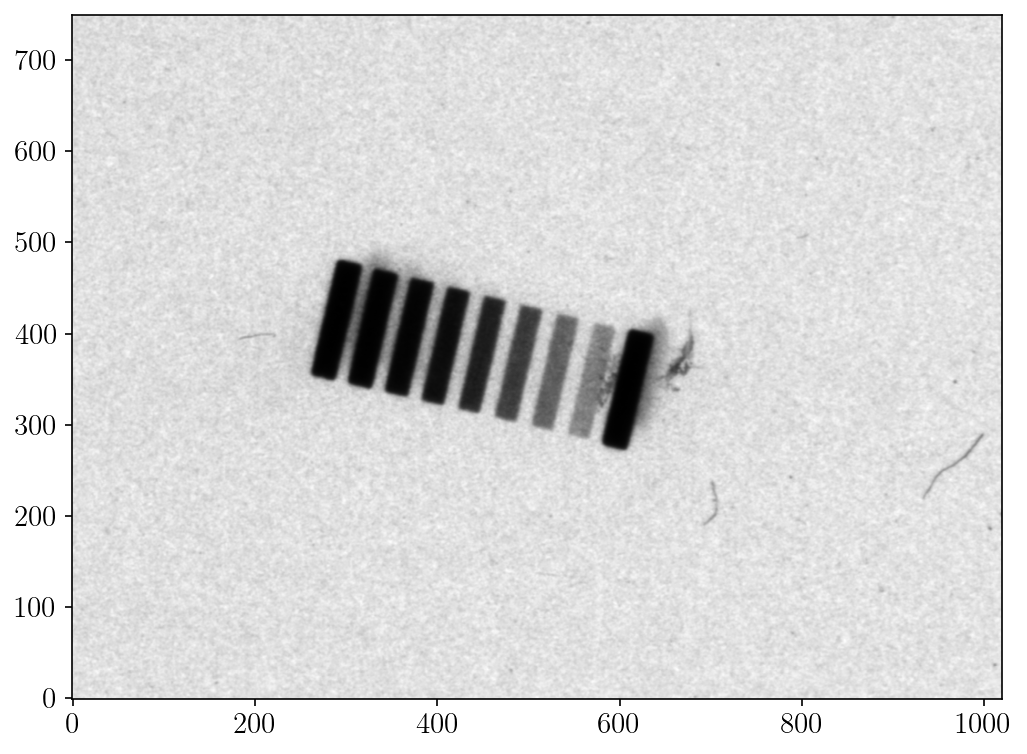

In [10]:
fits_cal_40s_full = fits.open('Calibrovka_04-05.02.1976_40s_XVI-6-Cal.fit.fits')[0].data
data_cal_40s_full = fits_cal_40s_full[750:1500,800:1820]
plt.figure(figsize=(8,6),dpi = 150)
plt.imshow(data_cal_40s_full, cmap="gray")
#x = np.arange(0,len(data_cal_40s_full[0]))
#plt.plot(x,y_func(x,-0.23,410),lw=3,c="r")
plt.gca().invert_yaxis()
#plt.axes(None)

-12.952764513375513


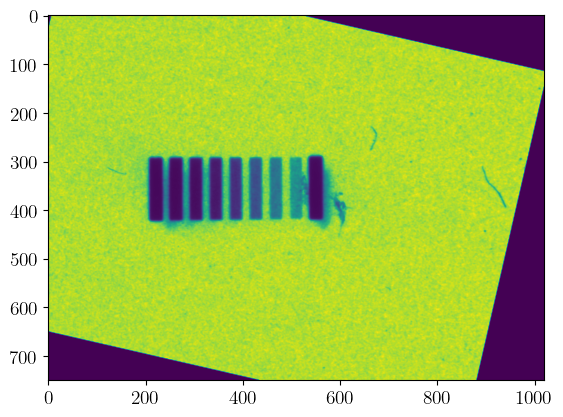

In [11]:
aligned_im=line_rotate(data_cal_40s_full, -0.23,410)

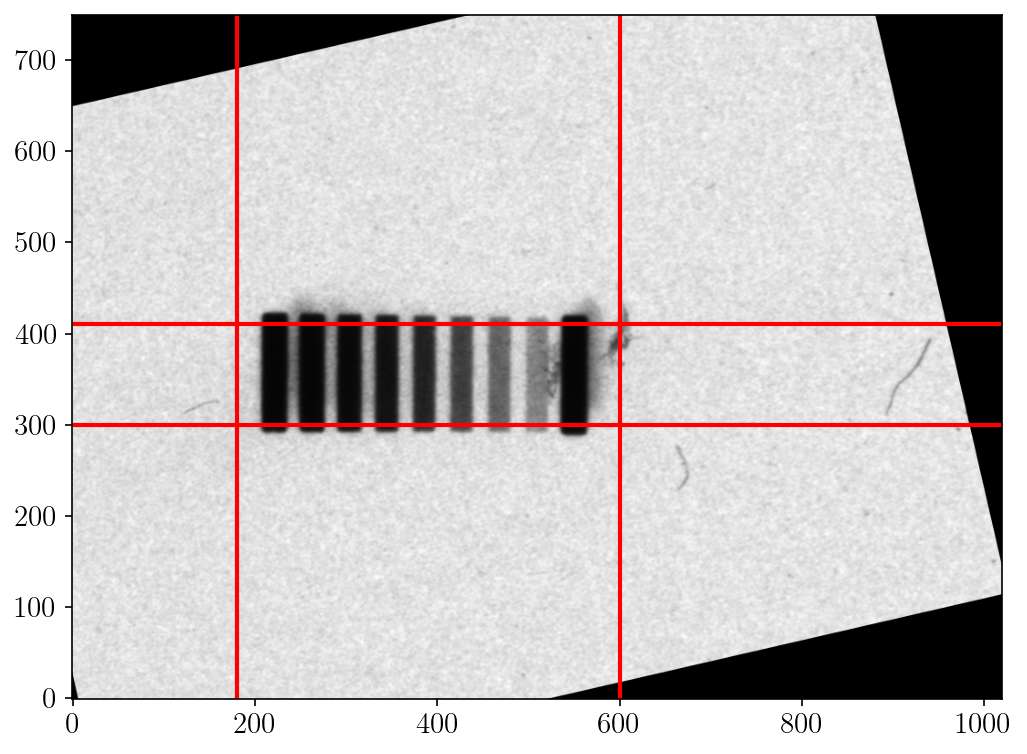

In [12]:
plt.figure(figsize=(8,6),dpi = 150)
plt.imshow(aligned_im,cmap="gray")
plt.axhline(300,lw=2,c="r")
plt.axhline(410,lw=2,c="r")
plt.axvline(180,lw=2,c="r")
plt.axvline(600,lw=2,c="r")
plt.gca().invert_yaxis()

In [15]:
data_cal_2s  = fits_cal_2s[0].data
data_cal_5s  = fits_cal_5s[0].data
data_cal_10s = fits_cal_10s[0].data
data_cal_20s = fits_cal_20s[0].data
data_cal_30s = fits_cal_30s[0].data
data_cal_40s = fits_cal_40s[0].data

In [16]:
mean_cal_2s = calib_preob(data_cal_2s )[::-1]
mean_cal_5s = calib_preob(data_cal_5s )[::-1]
mean_cal_10s= calib_preob(data_cal_10s)[::-1]
mean_cal_20s= calib_preob(data_cal_20s)#[::-1]
mean_cal_30s= calib_preob(data_cal_30s)#[::-1]
mean_cal_40s= calib_preob(data_cal_40s)#[::-1]

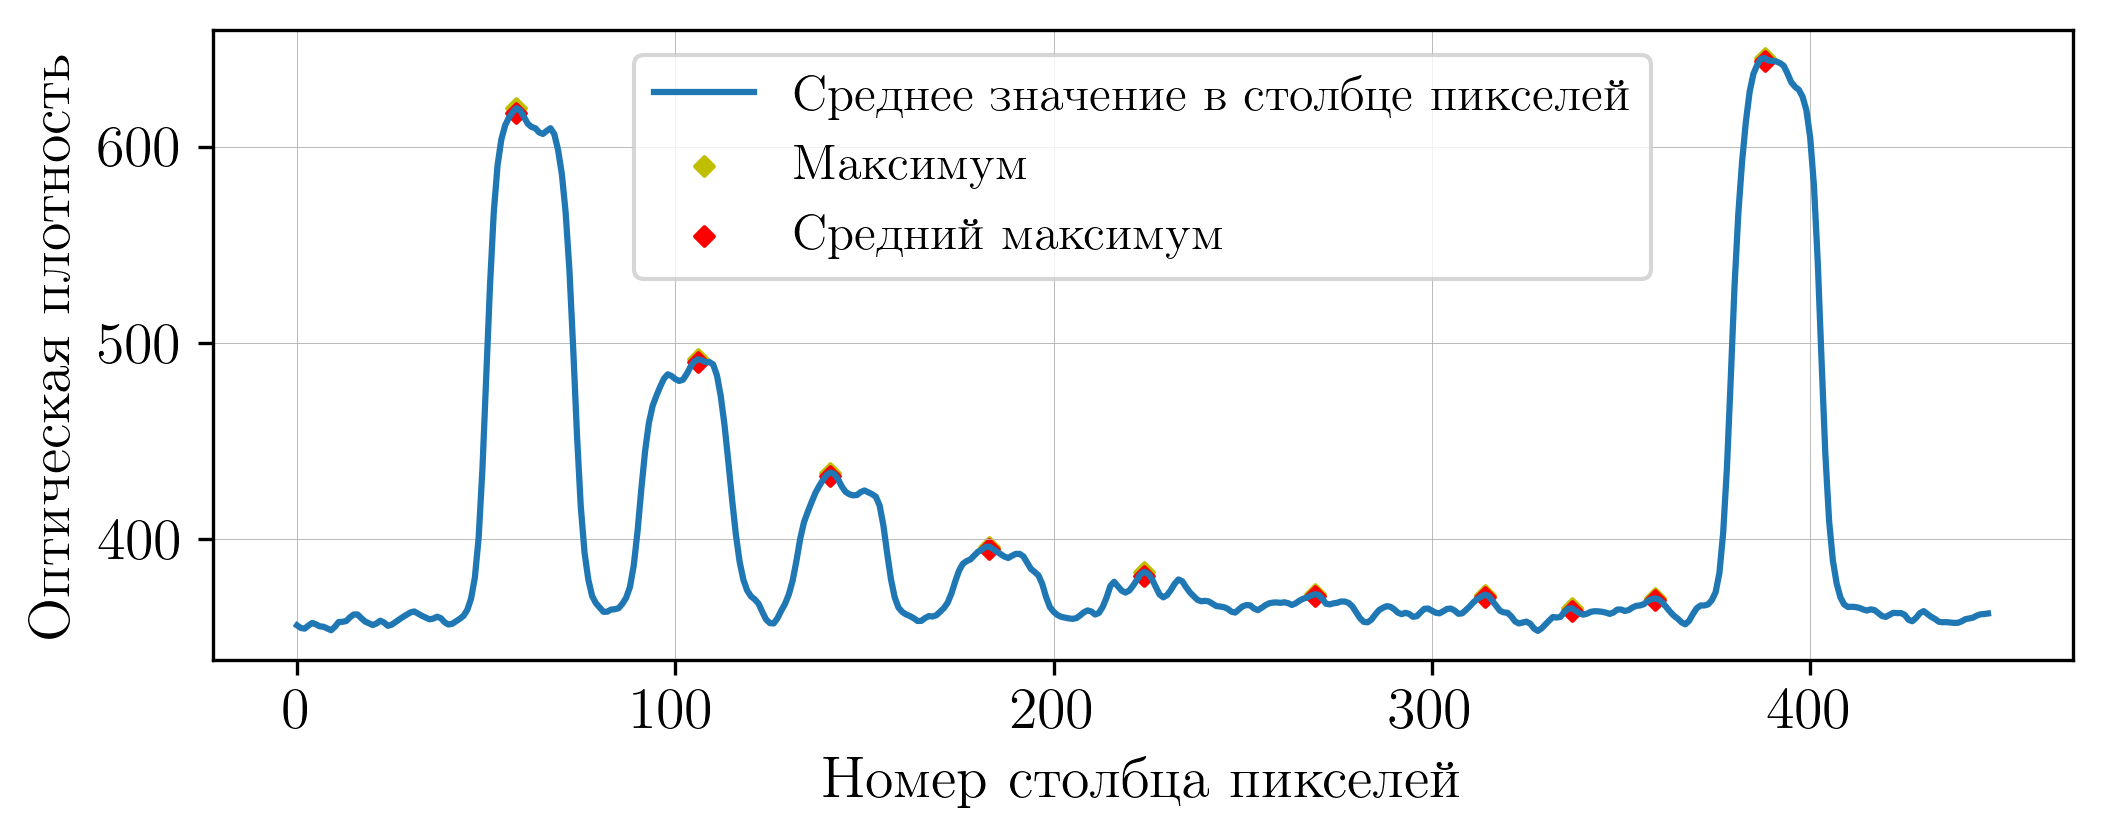

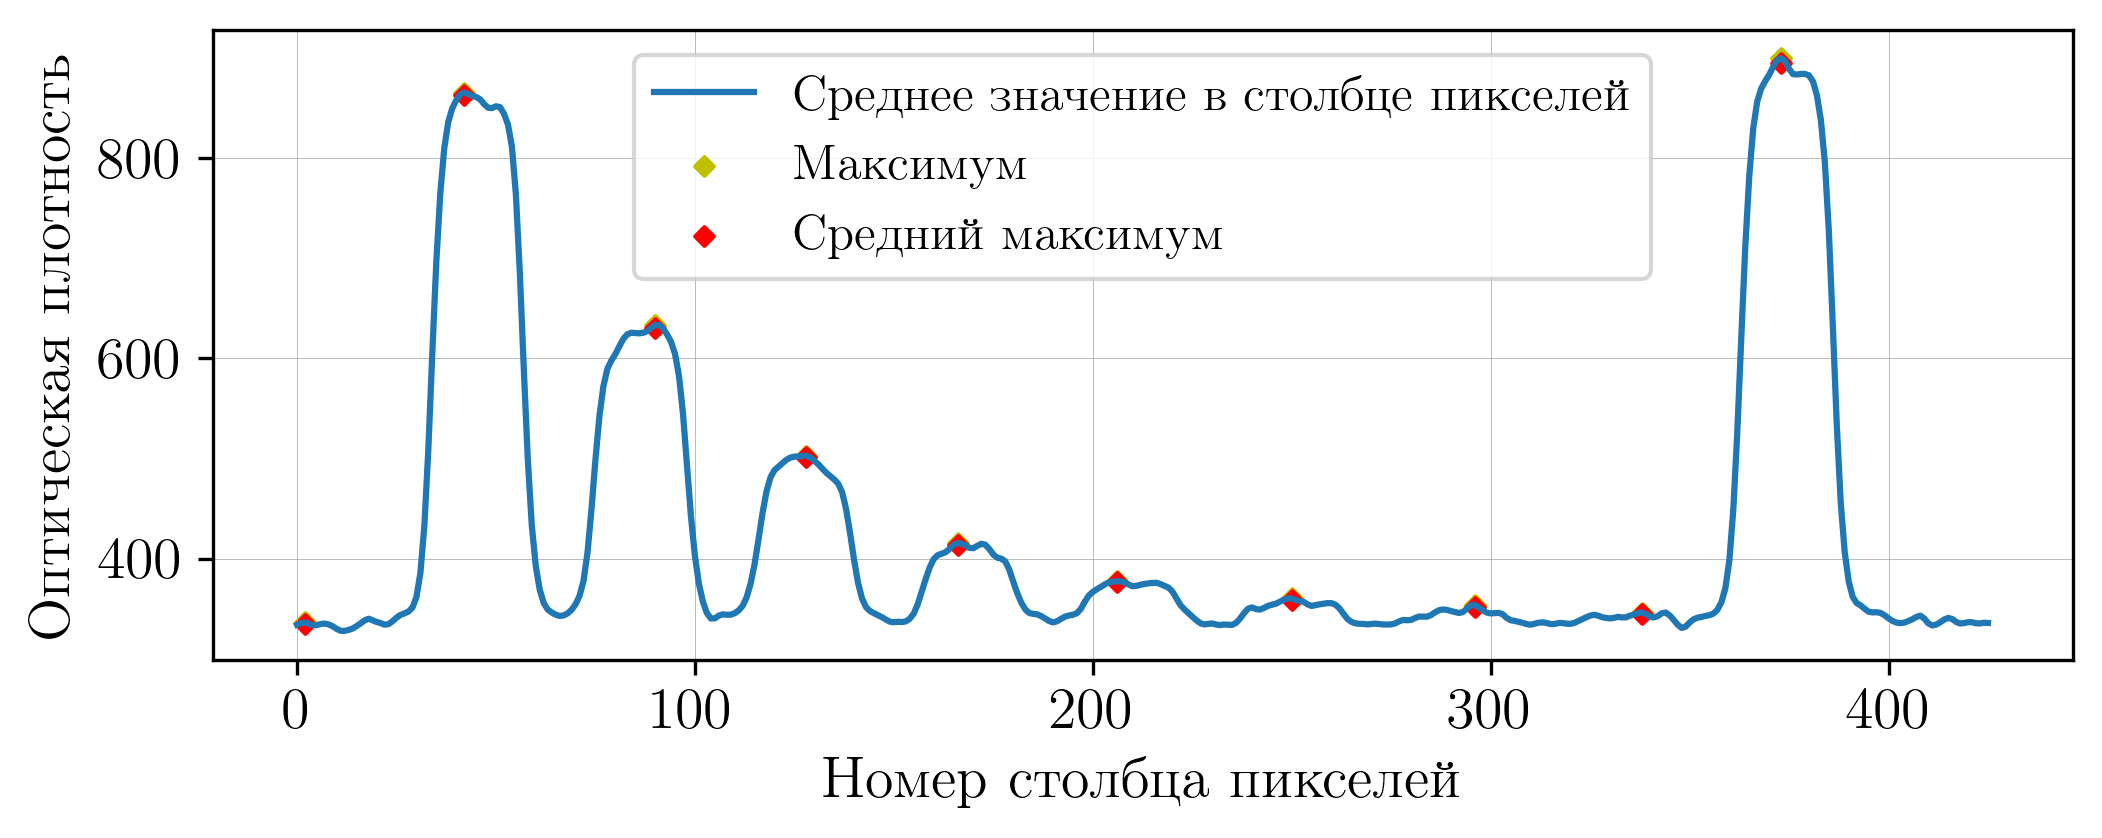

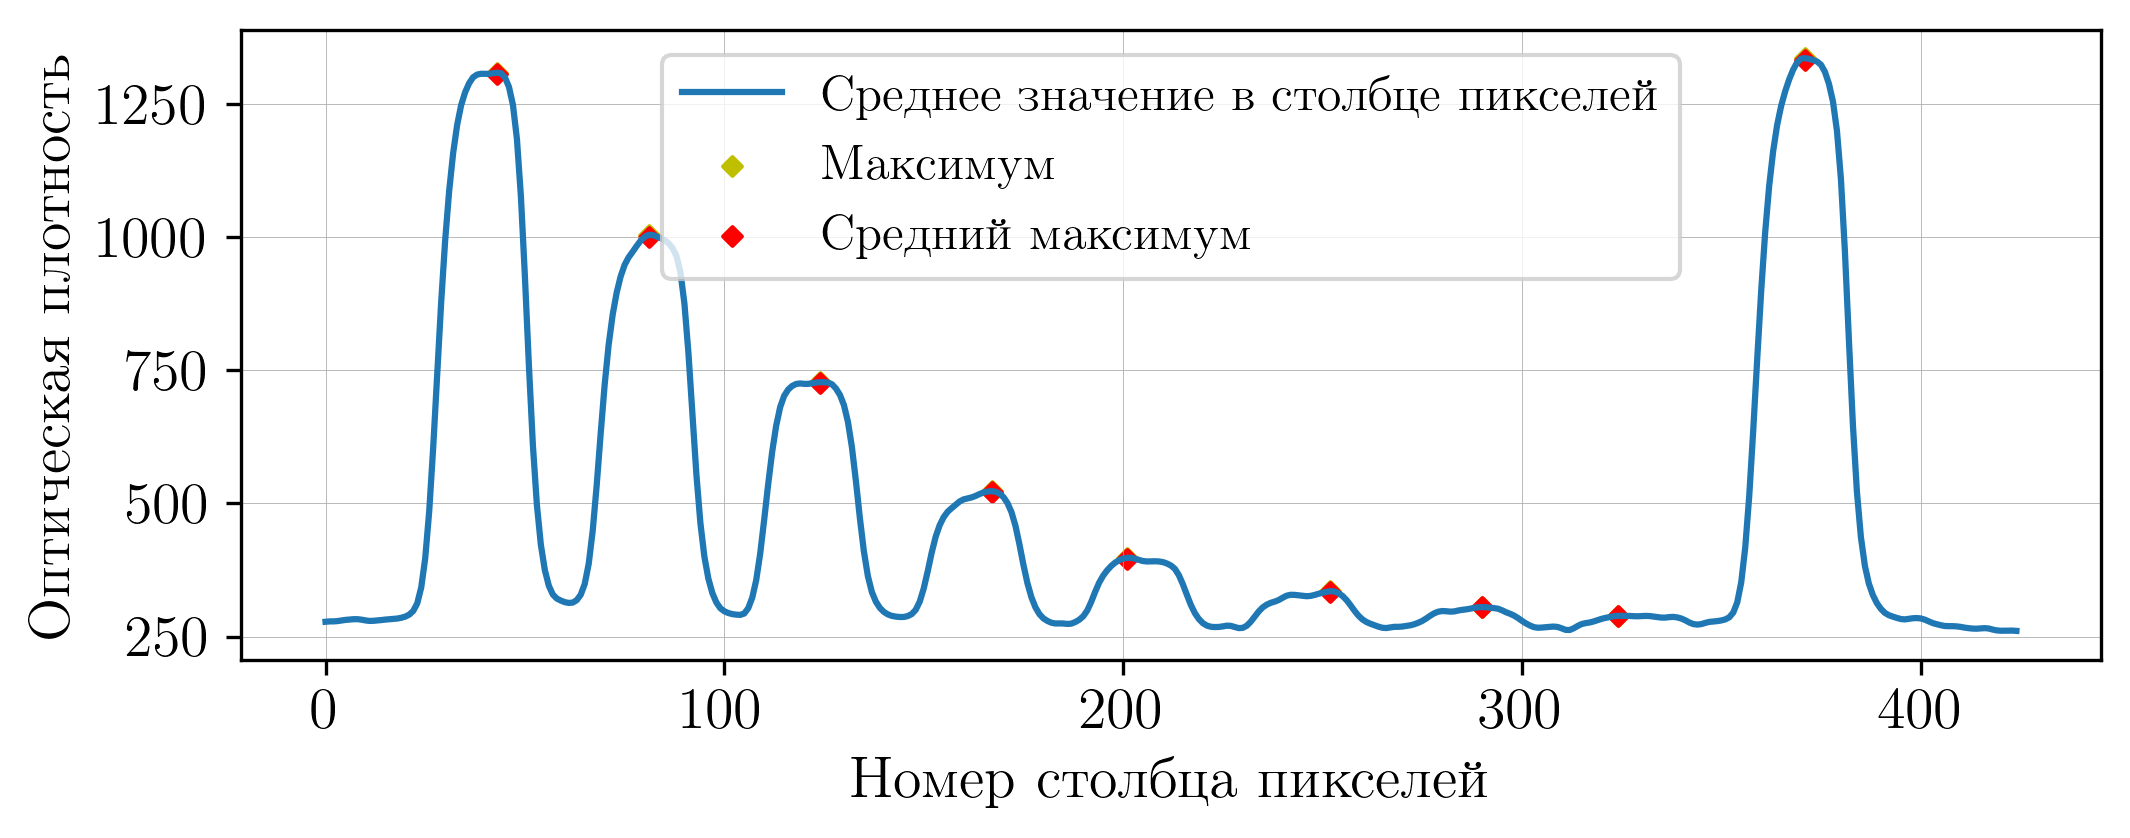

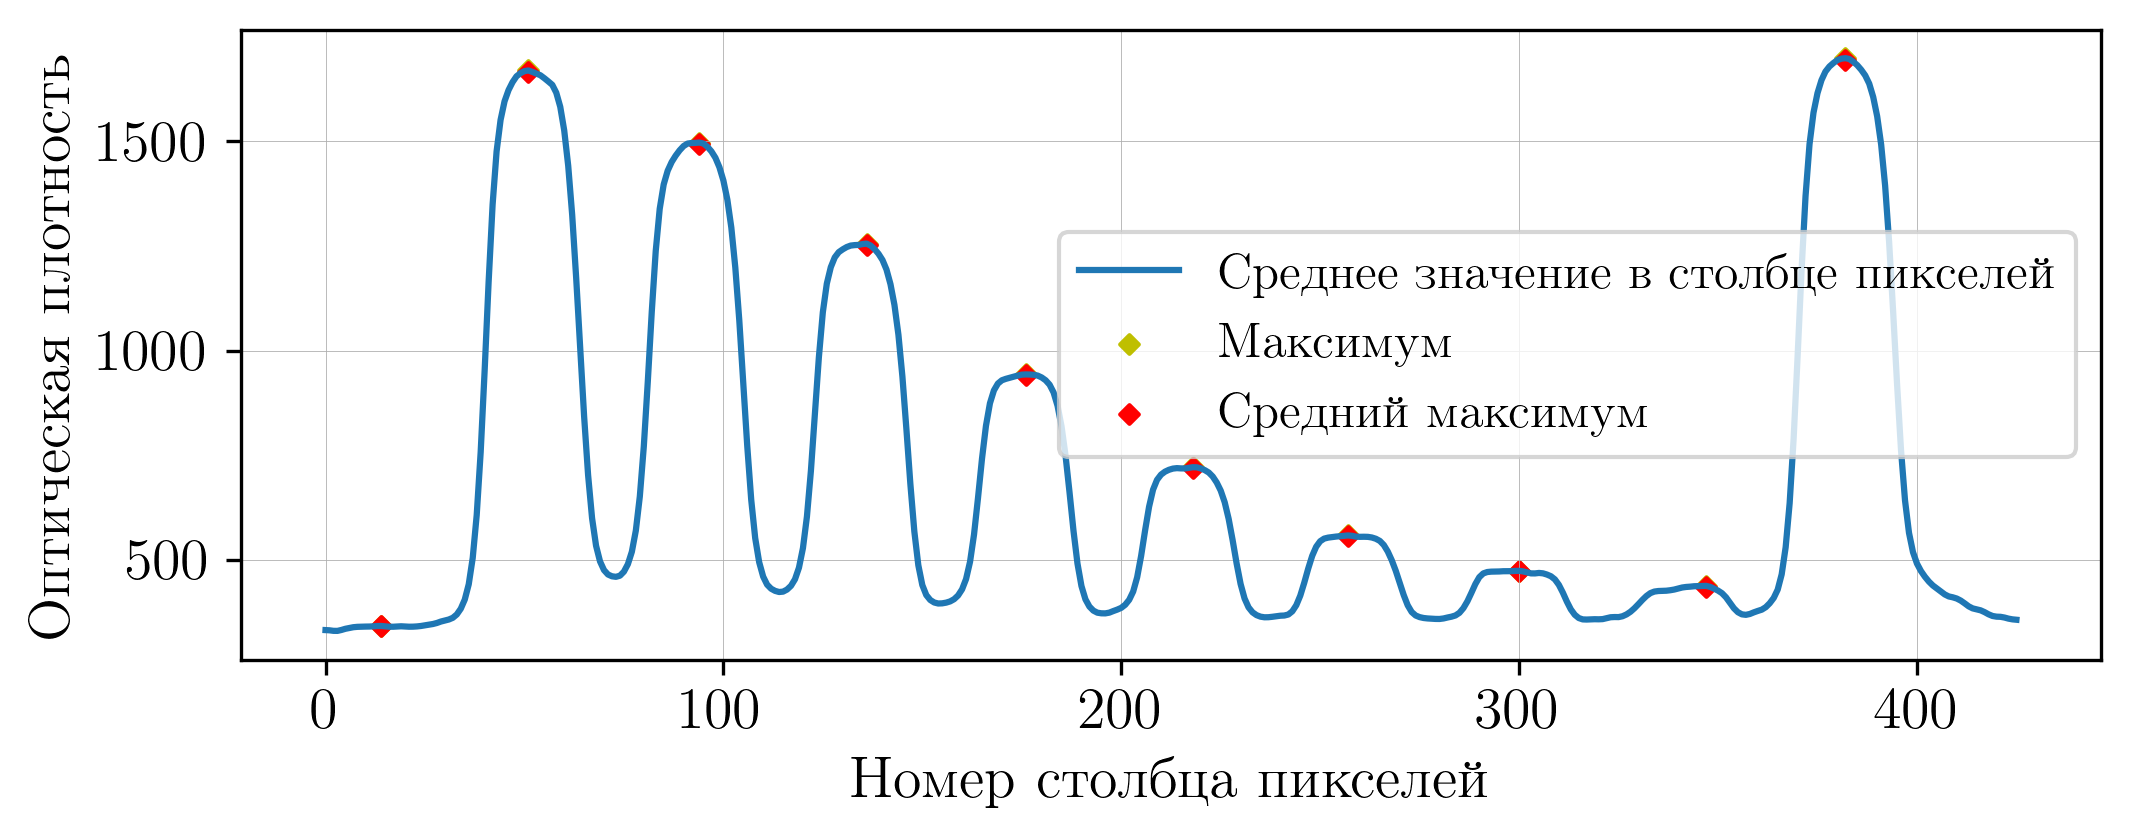

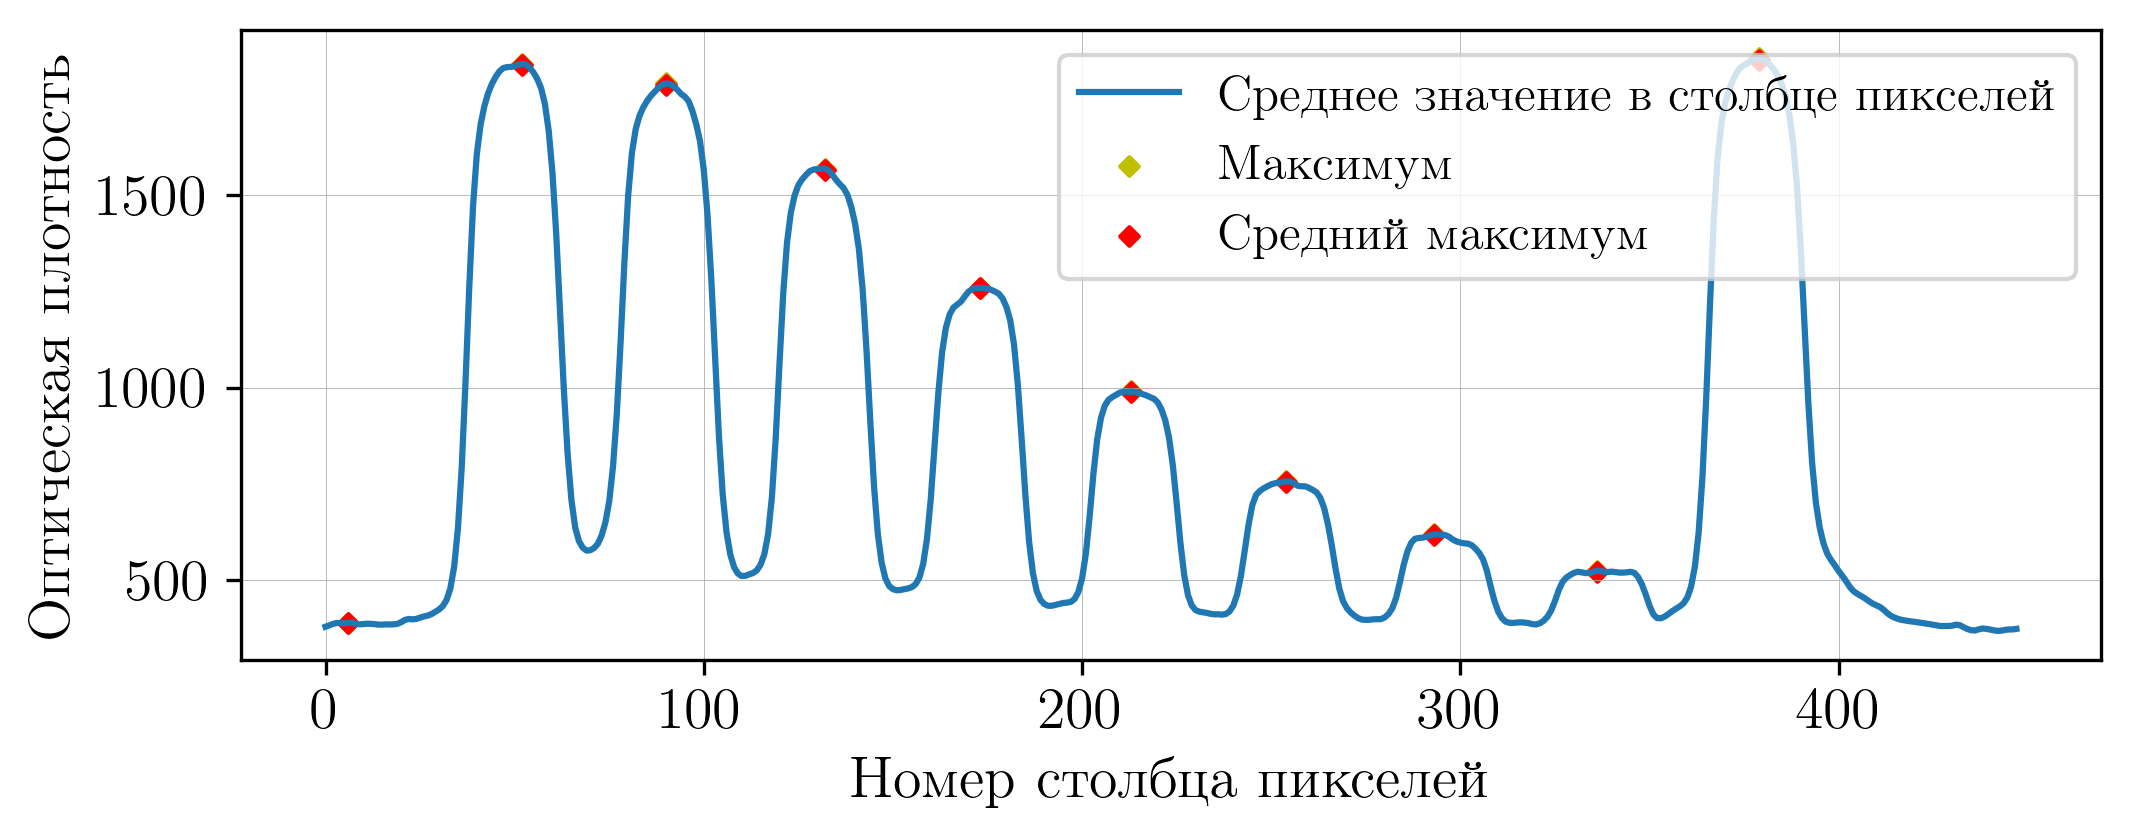

In [17]:
peaks_ind_2s,peaks_mean_2s=graf(mean_cal_2s  ,15)#[:-2]

peaks_ind_5s,peaks_mean_5s=graf(mean_cal_5s  ,10)#[1:-1]

peaks_ind_10s,peaks_mean_10s=graf(mean_cal_10s ,10)#[:-1]

peaks_ind_20s,peaks_mean_20s=graf(mean_cal_20s ,10)#[1:]

peaks_ind_30s,peaks_mean_30s=graf(mean_cal_30s ,10)#[1:-1]

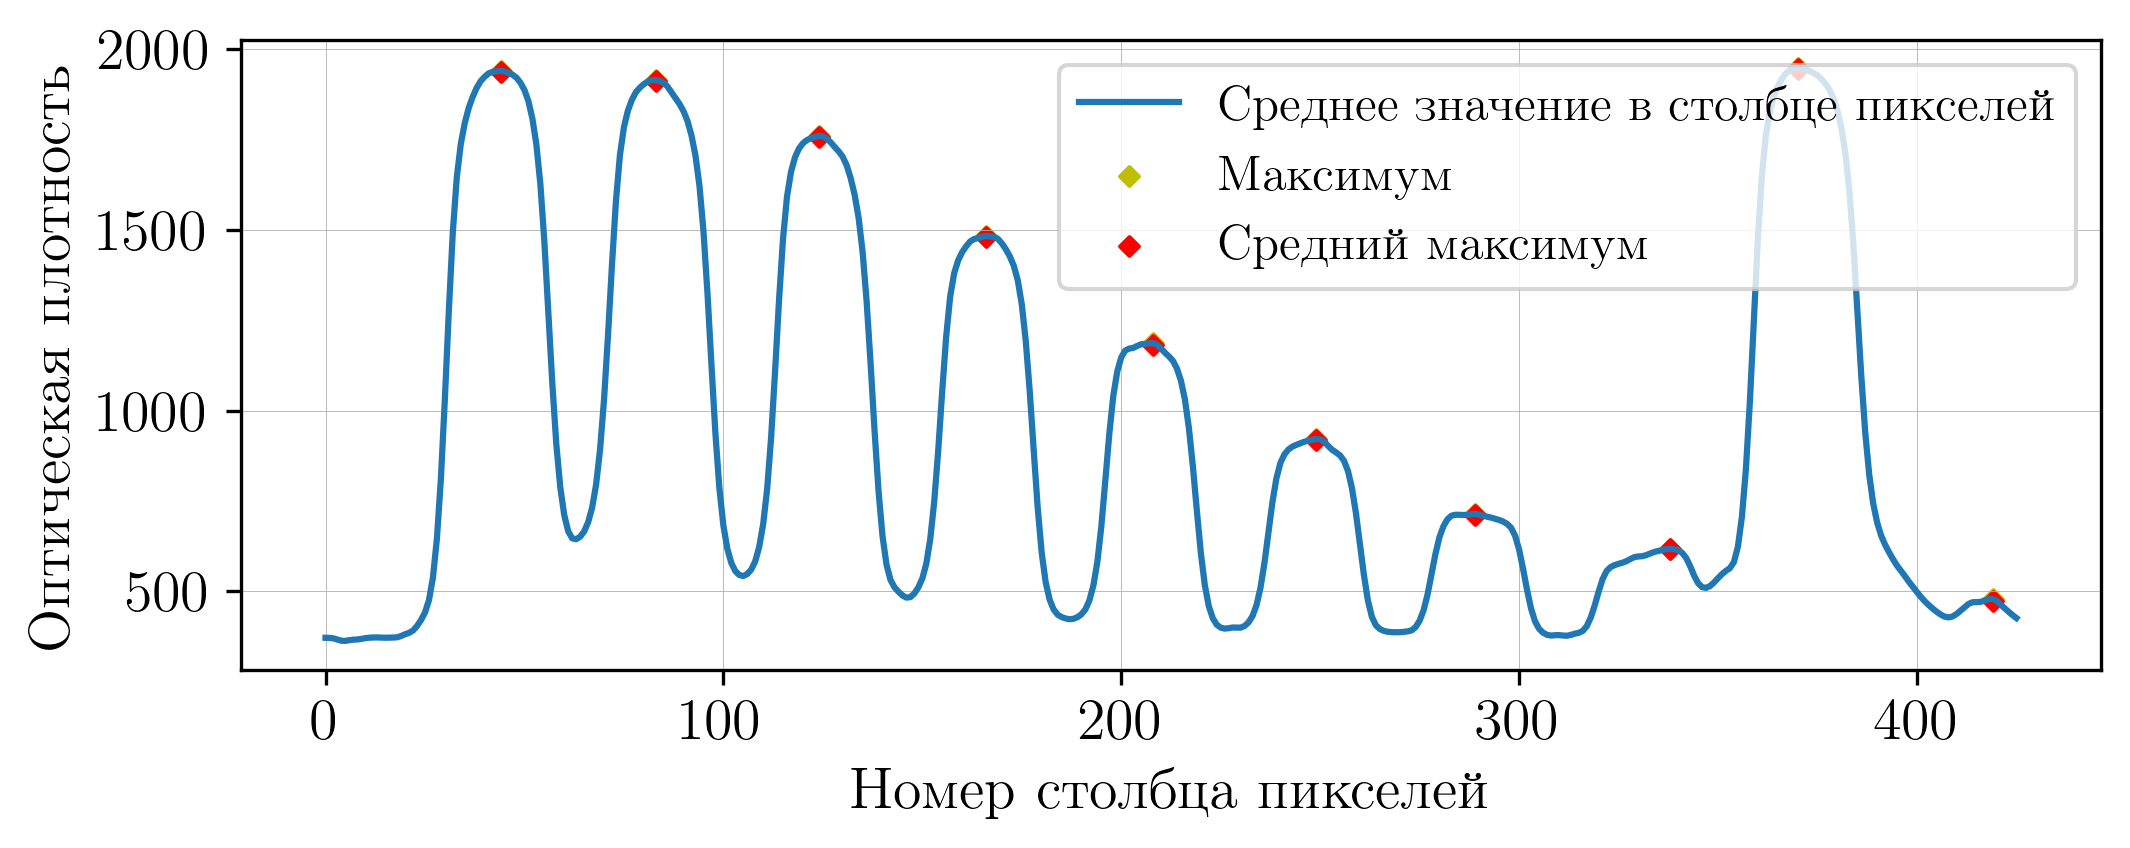

In [18]:
peaks_ind_40s,peaks_mean_40s=graf(mean_cal_40s ,12)#[:-2]

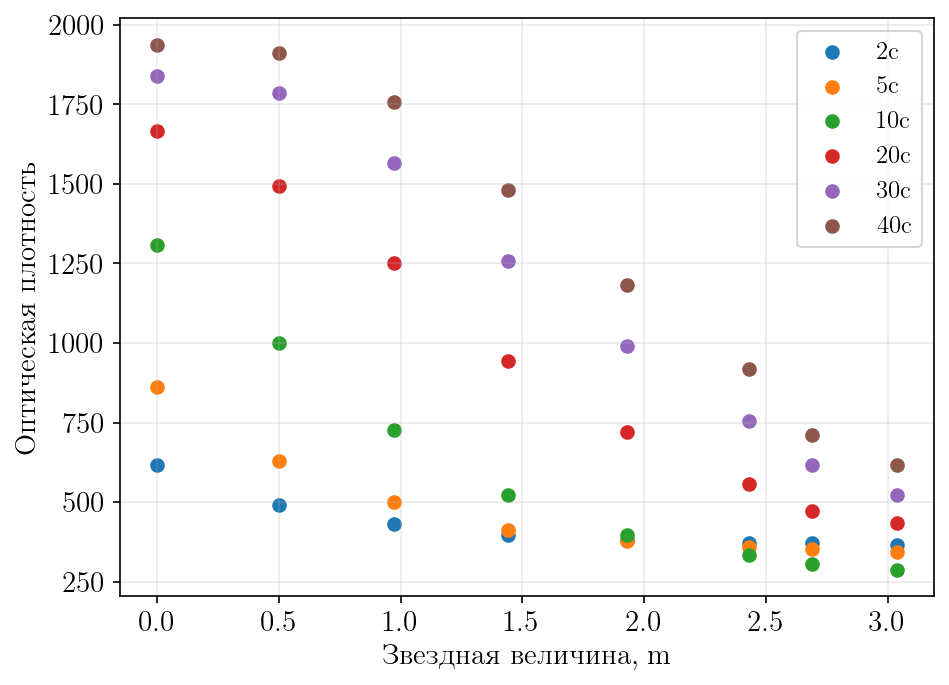

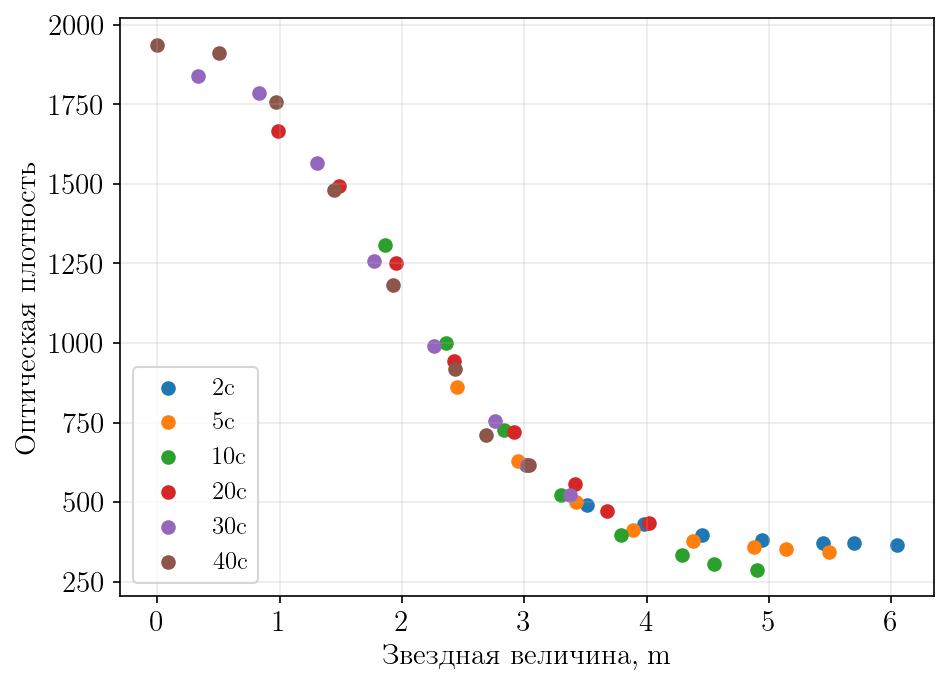

In [19]:
delta_m1 = 2.5*np.log(40/12)
delta_m2 = 2.5*np.log(40/15)
delta_m3 = 2.5*np.log(40/19)
delta_m4 = 2.5*np.log(40/27)
delta_m5 = 2.5*np.log(40/35)
delta_m6 = 2.5*np.log(40/40)


fig1 = plt.figure(figsize=(7,5),dpi=150)
ax1 = fig1.add_subplot(1,1,1)
ax1.scatter(mag_after_1972[:-1],peaks_mean_2s[:-2]   , label="2c")
ax1.scatter(mag_after_1972[:-1],peaks_mean_5s[1:-1]  , label="5c")
ax1.scatter(mag_after_1972[:-1],peaks_mean_10s[:-1]  , label="10c")
ax1.scatter(mag_after_1972[:-1],peaks_mean_20s[1:-1] , label="20c")
ax1.scatter(mag_after_1972[:-1],peaks_mean_30s[1:-1] , label="30c")
ax1.scatter(mag_after_1972[:-1],peaks_mean_40s[:-2]  , label="40c")

ax1.set_xlabel(r'Звездная величина, m',fontsize=14)
ax1.set_ylabel(r'Оптическая плотность',fontsize=14)
ax1.legend(fontsize=12, fancybox = True, shadow=False)
ax1.grid(lw=0.2)
#fig1.savefig('calib_step_initial.pdf')

fig2 = plt.figure(figsize=(7,5),dpi=150)

ax2 = fig2.add_subplot(1,1,1)
ax2.scatter(mag_after_1972[:-1]+delta_m1,peaks_mean_2s[:-2]   , label="2c")
ax2.scatter(mag_after_1972[:-1]+delta_m2,peaks_mean_5s[1:-1]  , label="5c")
ax2.scatter(mag_after_1972[:-1]+delta_m3,peaks_mean_10s[:-1]  , label="10c")
ax2.scatter(mag_after_1972[:-1]+delta_m4,peaks_mean_20s[1:-1] , label="20c")
ax2.scatter(mag_after_1972[:-1]+delta_m5,peaks_mean_30s[1:-1] , label="30c")
ax2.scatter(mag_after_1972[:-1]+delta_m6,peaks_mean_40s[:-2]  , label="40c")

ax2.set_xlabel(r'Звездная величина, m',fontsize=14)
ax2.set_ylabel(r'Оптическая плотность',fontsize=14)
ax2.legend(loc=3,fontsize=12, fancybox = True, shadow=False)
ax2.grid(lw=0.2)
#fig2.savefig('calib_step_shifted.pdf')

array = np.array([peaks_mean_2s[:-2]  , 
                  peaks_mean_5s[1:-1] ,
                  peaks_mean_10s[:-1] ,   
                  peaks_mean_20s[1:-1]  , 
                  peaks_mean_30s[1:-1],
                  peaks_mean_40s[:-2] ])


y_array = np.concatenate(array)
x_array = np.concatenate([mag_after_1972[:-1]+delta_m1,
                          mag_after_1972[:-1]+delta_m2,
                          mag_after_1972[:-1]+delta_m3,
                          mag_after_1972[:-1]+delta_m4,
                          mag_after_1972[:-1]+delta_m5,
                          mag_after_1972[:-1]+delta_m6])

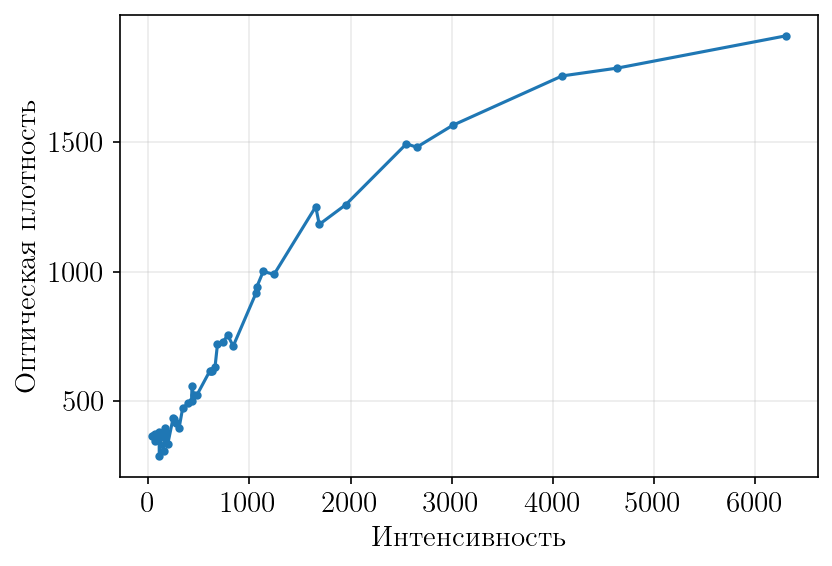

In [20]:
intensity, dark = mean_deviation(x_array,y_array)

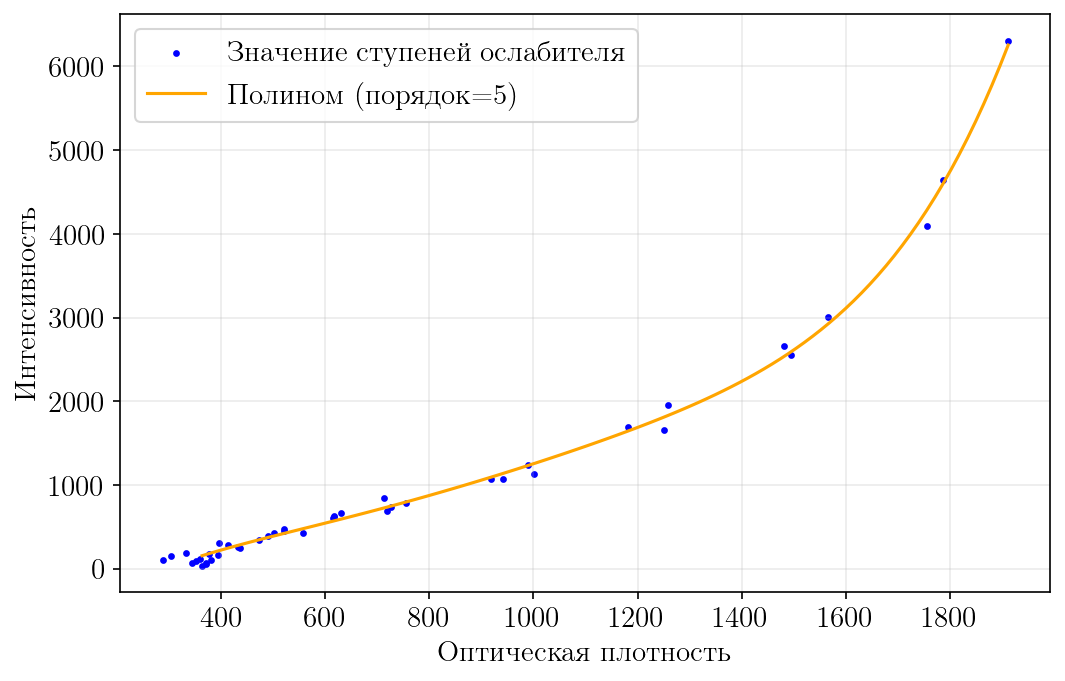

In [21]:
polynomial_func = polynomial_aproximation(dark,intensity,5)

In [22]:
fits_ngc4151_1m_16box_fits = fits.open('ngc4151_1m.fits')[0].data


In [23]:
def y_func(x,k,b):
    return k*x+b

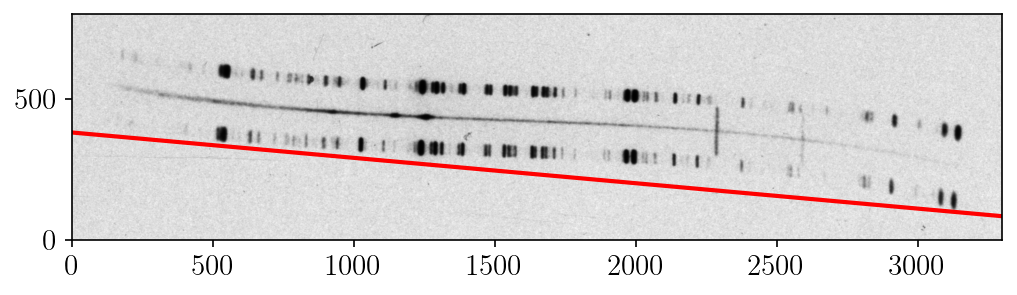

In [24]:
fits_ngc4151_1m_16box_fits = fits.open('NGC4151_04-05.02.1976_1m_XVI-6.fit.fits')
data_ngc4151_1m_16box = fits_ngc4151_1m_16box_fits[0].data[600:1400,:3300]
plt.figure(figsize=(8,6),dpi = 150)
plt.imshow(data_ngc4151_1m_16box,cmap="gray")
x = np.arange(0,len(data_ngc4151_1m_16box[0]))
plt.plot(x,y_func(x,-0.09,380),lw=2,c="r")
plt.gca().invert_yaxis()

-5.14276455788422


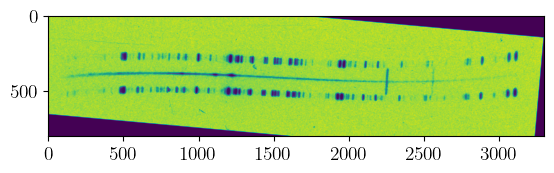

In [25]:
aligned_im=line_rotate(data_ngc4151_1m_16box, -0.09,380)

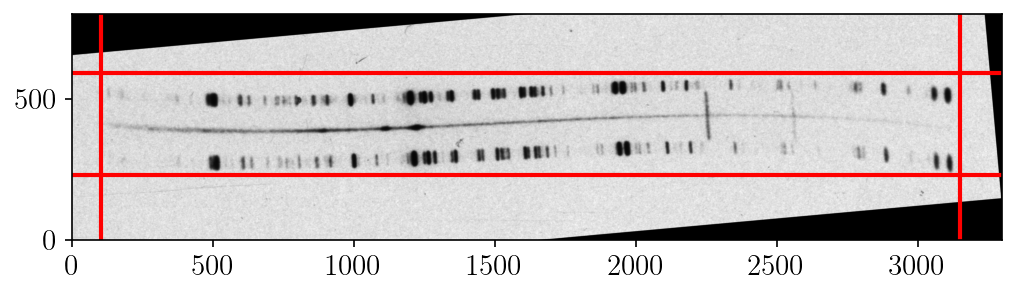

In [26]:
plt.figure(figsize=(8,6),dpi = 150)
plt.imshow(aligned_im,cmap="gray")
plt.axhline(230,lw=2,c="r")
plt.axhline(590,lw=2,c="r")
plt.axvline(100,lw=2,c="r")
plt.axvline(3150,lw=2,c="r")
plt.gca().invert_yaxis()

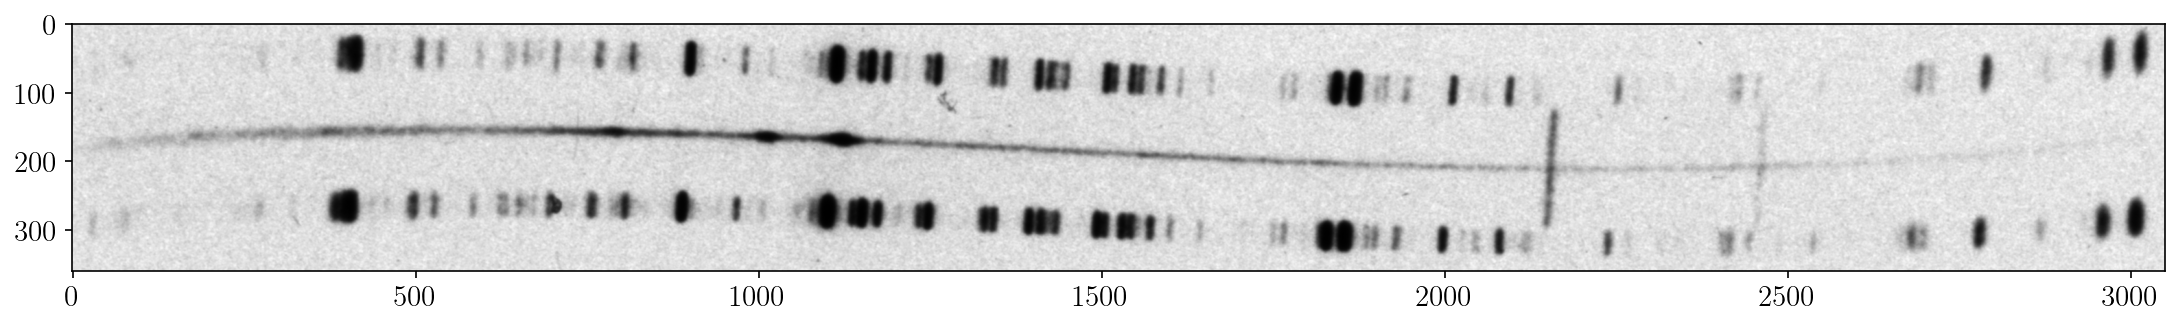

In [34]:
aligned_image = aligned_im[230:590,100:3150]
plt.figure(figsize=(18,9),dpi = 150)
plt.imshow(aligned_image,cmap="gray")

DATA AFTER MANAS PROG  uint16
(array([68.18402952, 90.51255996]), array([1187512.46960526, 1178509.46605301]), array([146.0580408 , 241.53273492]), array([214.24207031, 332.04529488]))
ZEROES  uint16
(array([29.50615045]), array([1186839.47105534]), array([67.80401626]), array([97.31016671]))
DATA PART2 before spectra back  uint16
SPECTRA BACK BEFORE  uint16
SPECTRA BACK AFTER  float64
len(xppp)= 532
len(y_poly)= 532
BEFORE CV2  uint16
AFTER CV2  uint16


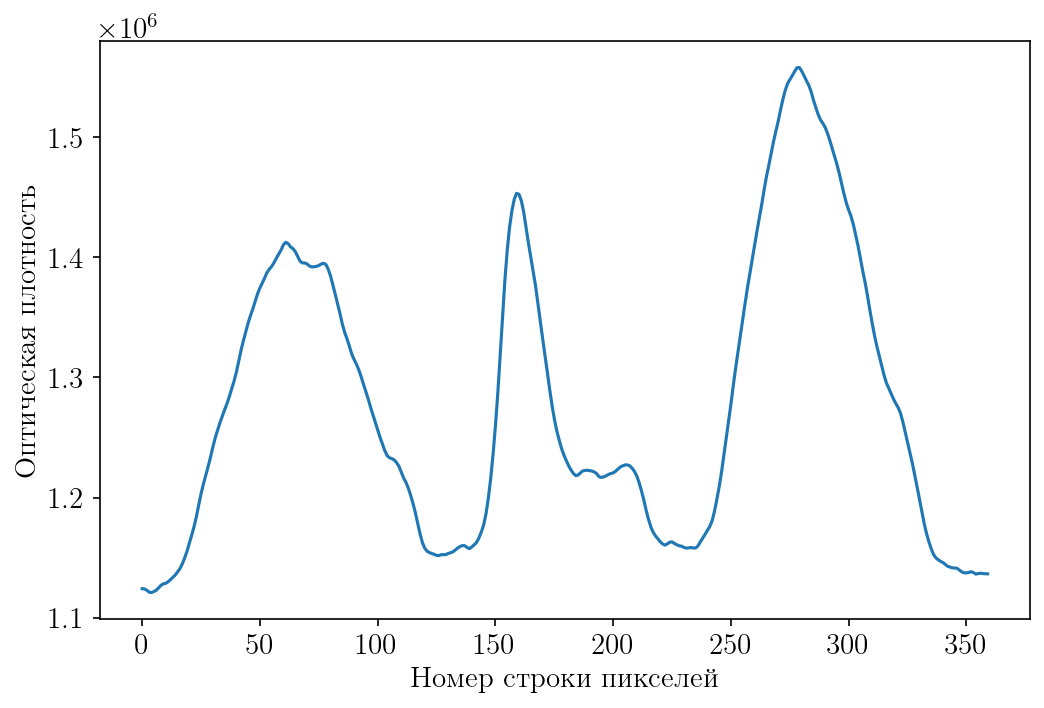

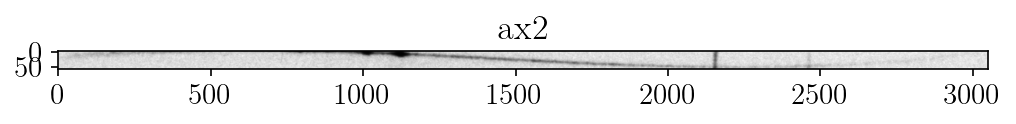

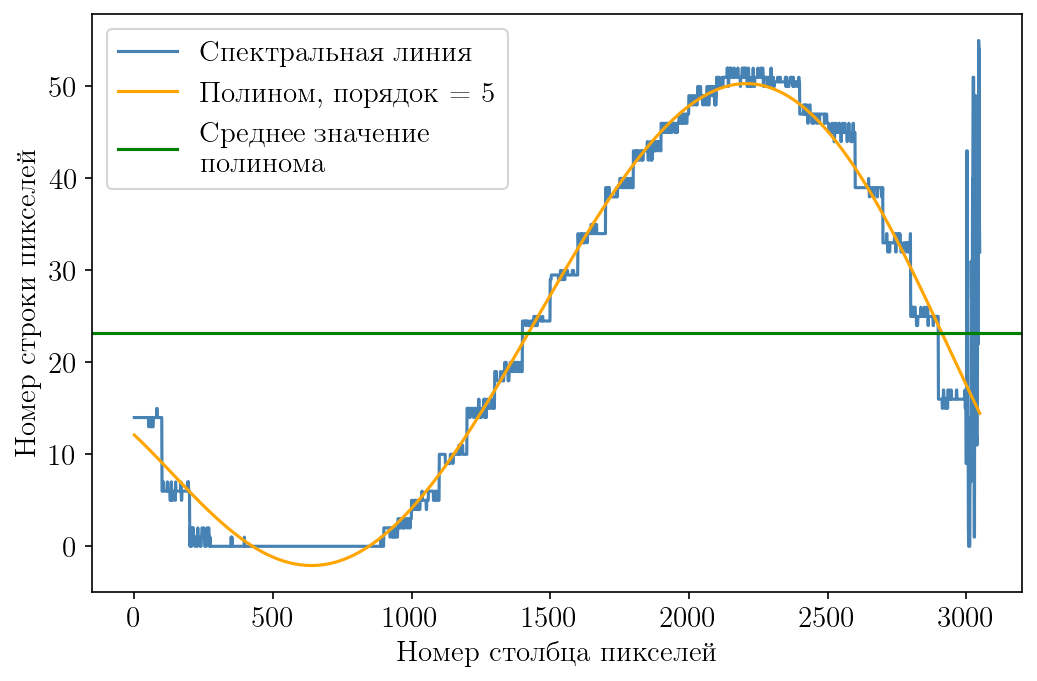

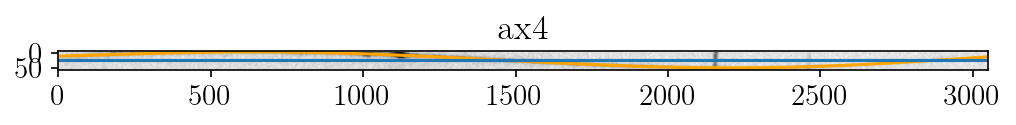

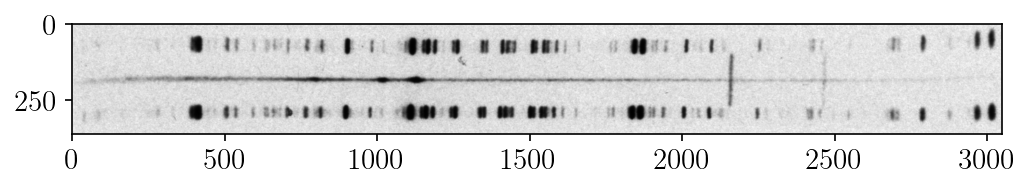

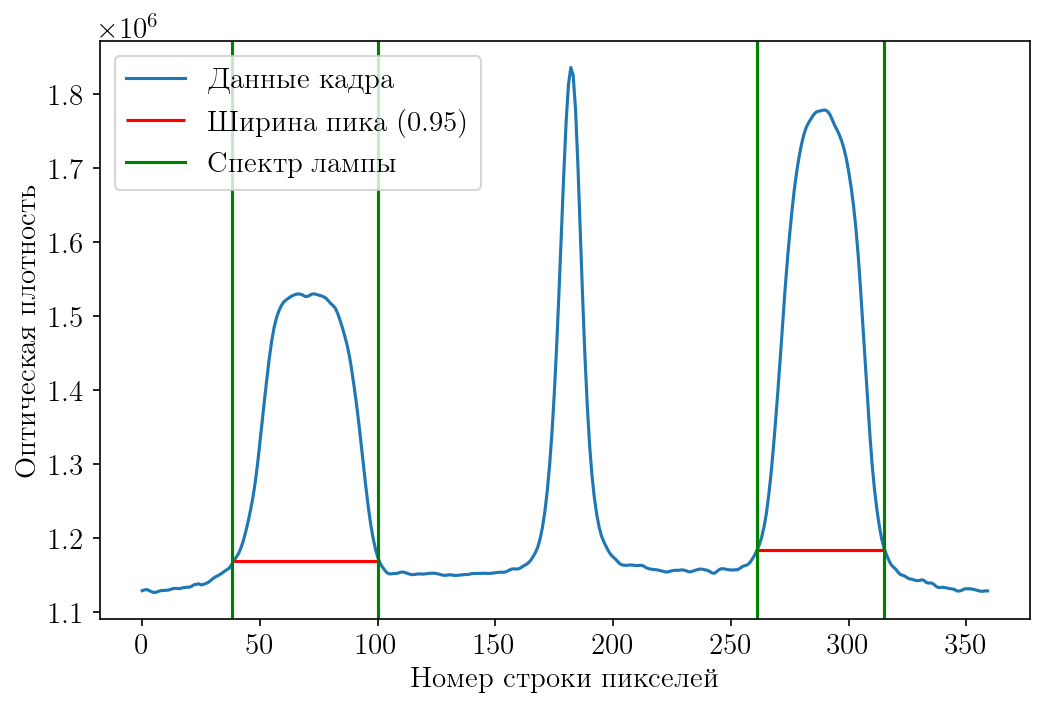

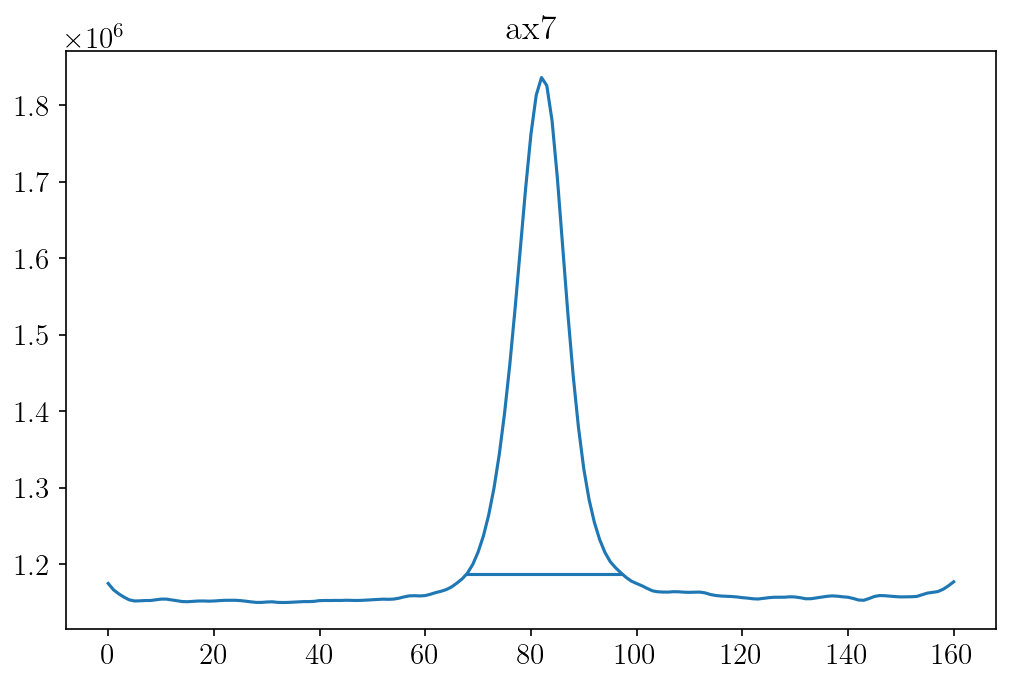

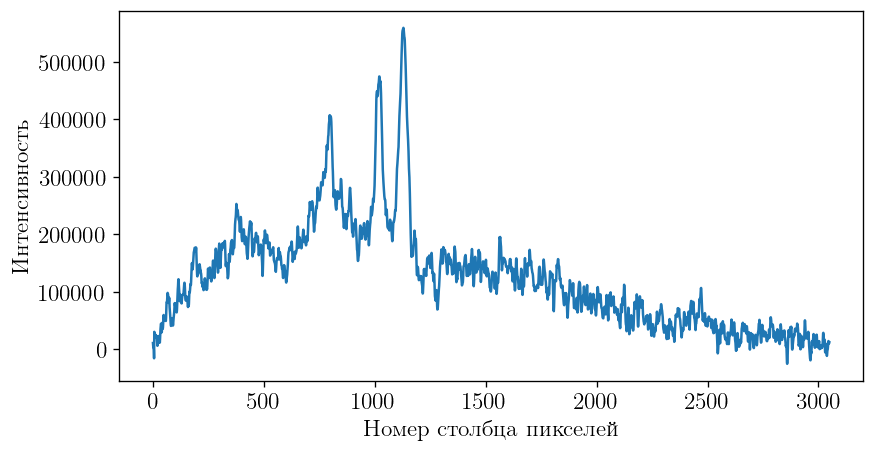

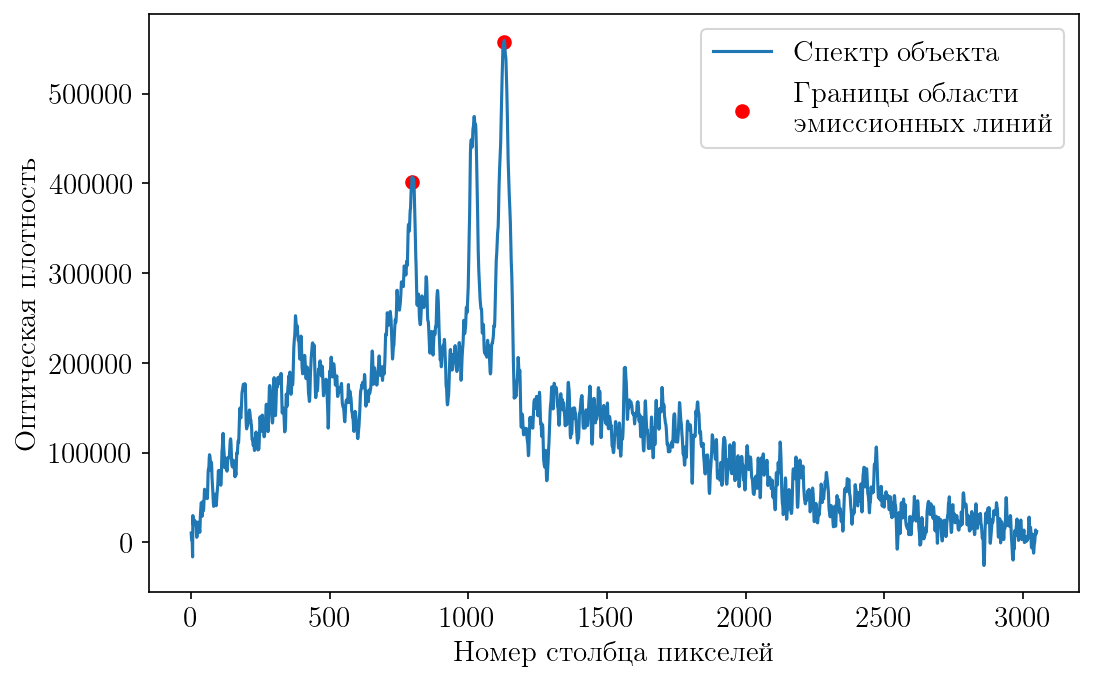

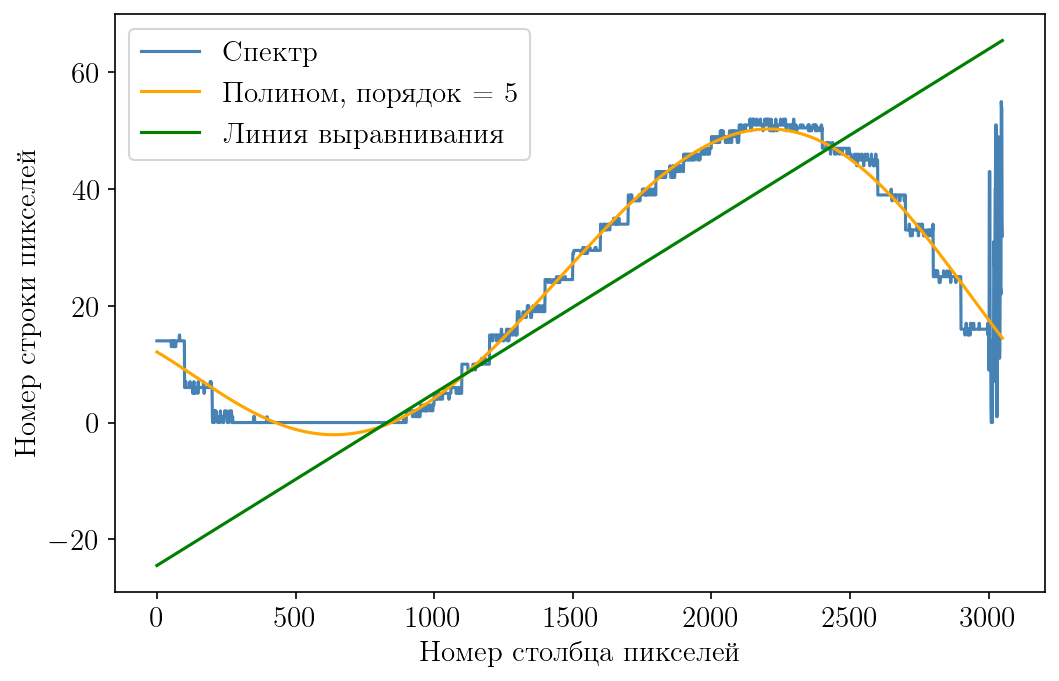

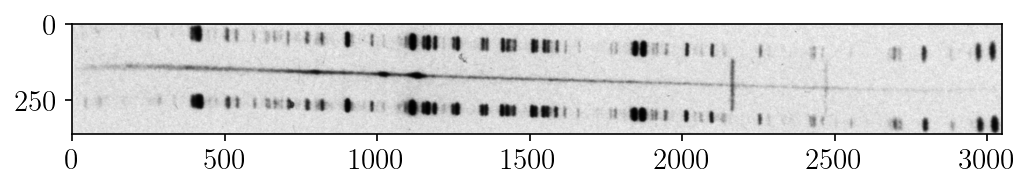

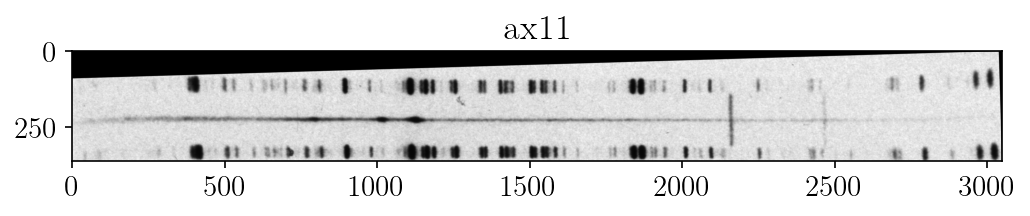

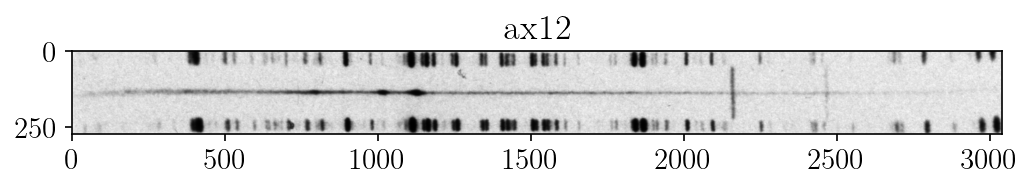

In [41]:
aligned_image = polynomial_alighn(aligned_image,5)

/var/folders/kv/prhthx396zd4k1d7f55bdztc0000gn/T/ipykernel_63274/778156631.py:1: RuntimeWarning: divide by zero encountered in divide
  data_ngc4151_1m_16box = np.array(np.log10(65535/aligned_im)*1000, dtype= 'uint16') #сначало надо перейти


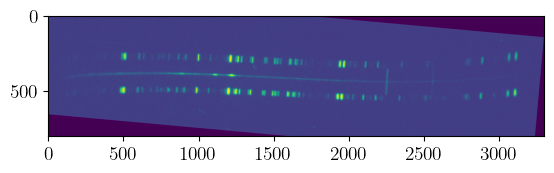

In [31]:
data_ngc4151_1m_16box = np.array(np.log10(65535/aligned_im)*1000, dtype= 'uint16') #сначало надо перейти 
plt.imshow(data_ngc4151_1m_16box)

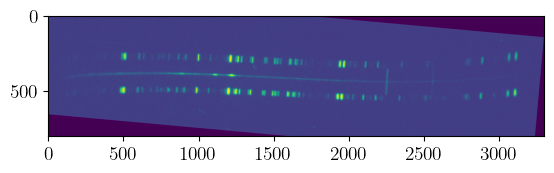

In [37]:
plt.imshow(data_ngc4151_1m_16box)

ngc4151 float64


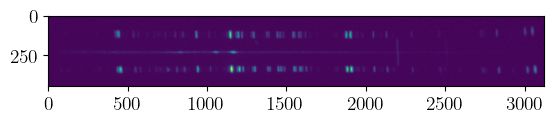

In [245]:
data_ngc4151_poly = np.array(polynomial_func(data_ngc4151_1m_16box))
print('ngc4151',data_ngc4151_poly.dtype)
plt.imshow(data_ngc4151_poly )

In [ ]:
data_ngc4151_1m_16box

In [ ]:
data_ngc4151_1m_16box_aligned_intence = fits_ngc4151_1m_16box_fits
data_ngc4151_1m_16box_aligned_intence[0].data = aligned_image
data_ngc4151_1m_16box_aligned_intence.writeto('data_ngc4151_1m_16box_aligned_intence.fits', overwrite = True)

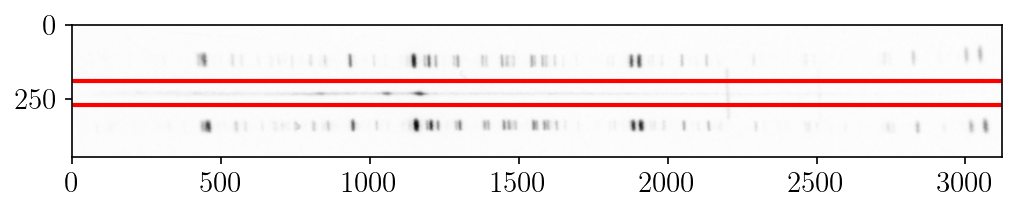

In [252]:
spectra_part = data_ngc4151_poly[190:270]
plt.figure(figsize=(8,6),dpi = 150)
plt.imshow(spectra_part.max()-spectra_part,cmap="gray")
plt.axhline(190 , c = "r",lw=2)
plt.axhline(270, c = "r",lw=2)

SPECTRA BACK BEFORE  float64
SPECTRA BACK AFTER  float64


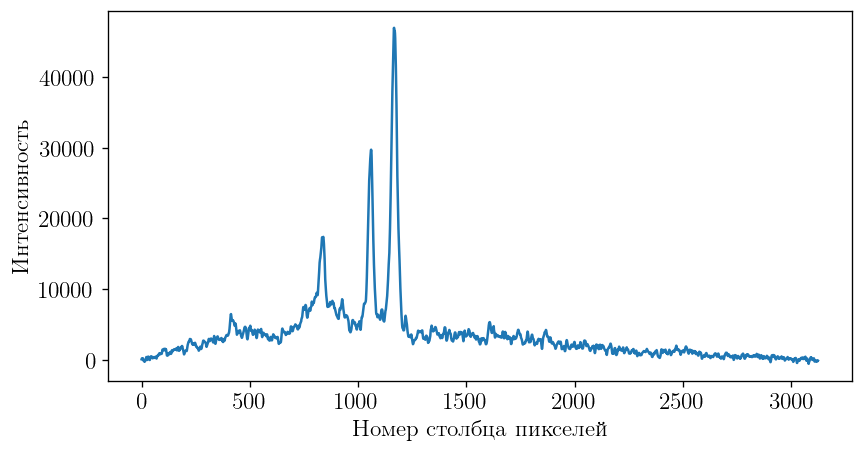

In [257]:
spectra = spectra_background(data_ngc4151_poly[190:270],37,49)#4spectra = spectra_background(spectra_part,37,49)#4

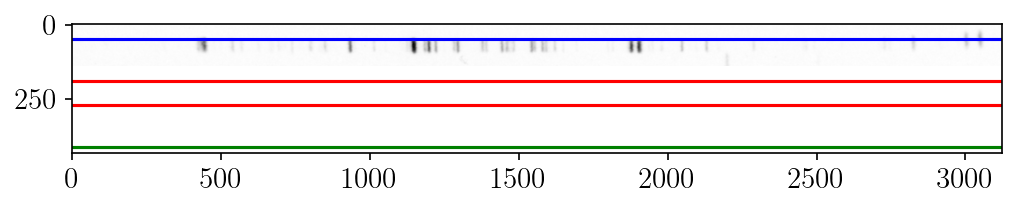

In [279]:
lamp1_part = data_ngc4151_poly[50:190]
plt.figure(figsize=(8,6),dpi=150)
plt.imshow(lamp1_part.max() -lamp1_part,cmap="gray")
plt.axhline(50 , c = "b",lw=1.5)
plt.axhline(190, c = "r",lw=1.5)
plt.axhline(270 , c ="r",lw=1.5)
plt.axhline(410, c = "g",lw=1.5)

SPECTRA BACK BEFORE  float64
SPECTRA BACK AFTER  float64


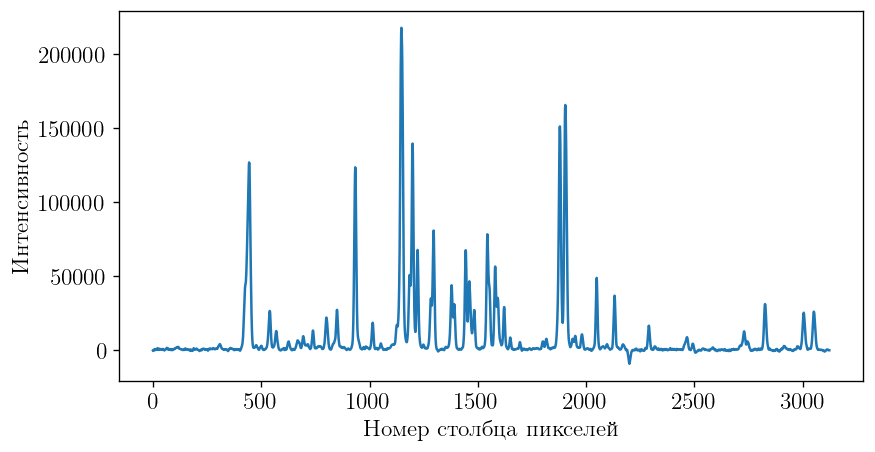

In [280]:
lamp1 = spectra_background(lamp1_part,50,90)#4

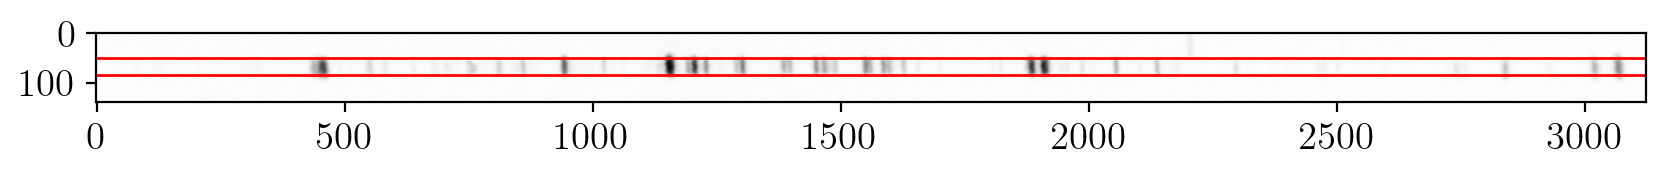

In [276]:
lamp2_part = data_ngc4151_poly[270:410]
plt.figure(figsize=(10,12),dpi=200)
plt.imshow(lamp2_part.max() -lamp2_part, cmap="gray")
plt.axhline(50 , c = "r",lw=1)
plt.axhline(85, c = "r",lw=1)

SPECTRA BACK BEFORE  float64
SPECTRA BACK AFTER  float64


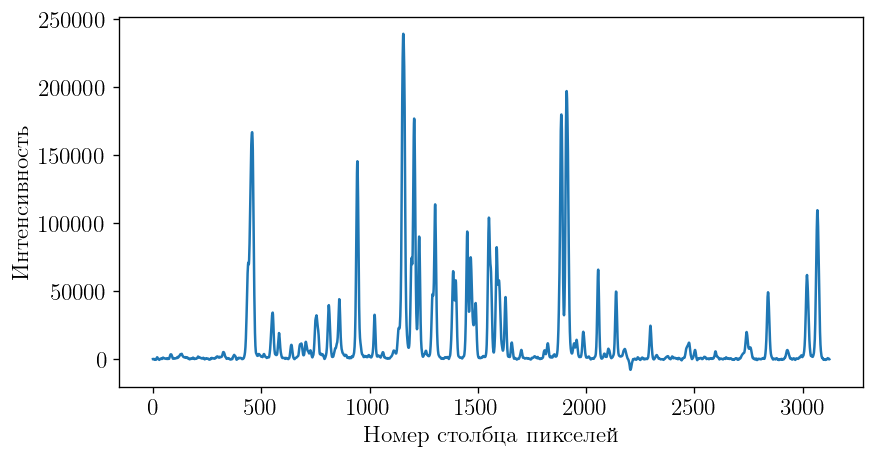

In [277]:
lamp2 = spectra_background(lamp2_part,50,90)#4

In [ ]:
plt.figure(figsize=(8,4),dpi=200)
plt.plot(np.arange(0,len(lamp1))+10,lamp1,lw=.2)
plt.plot(np.arange(0,len(lamp2)),lamp2,lw=.2)

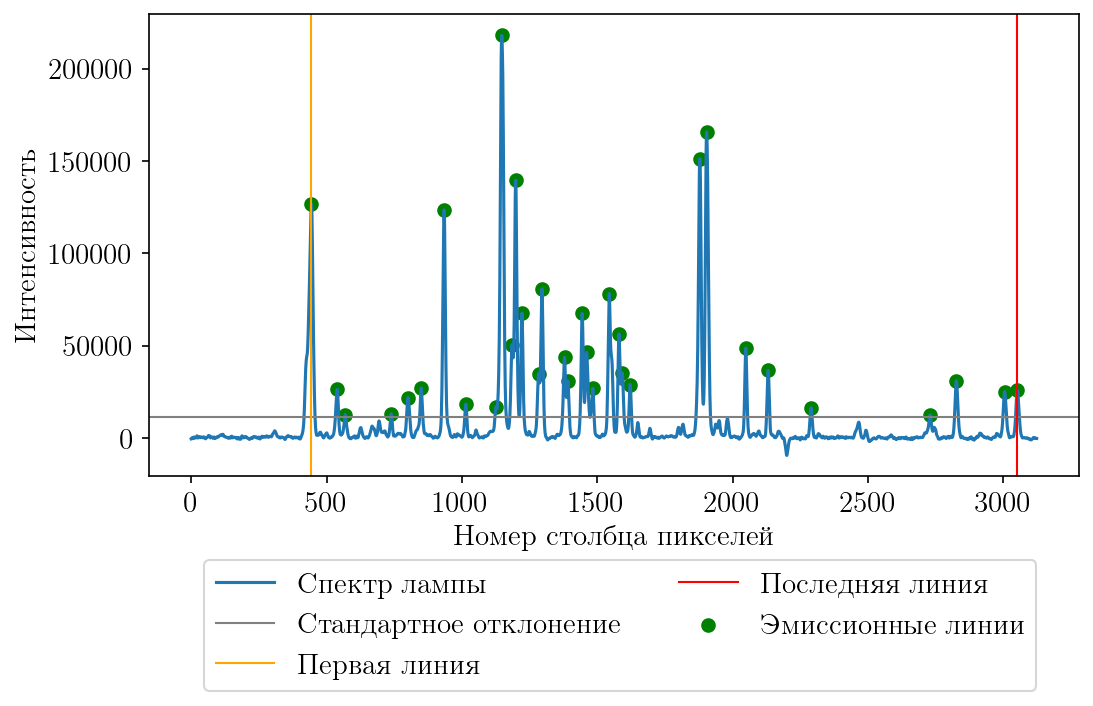

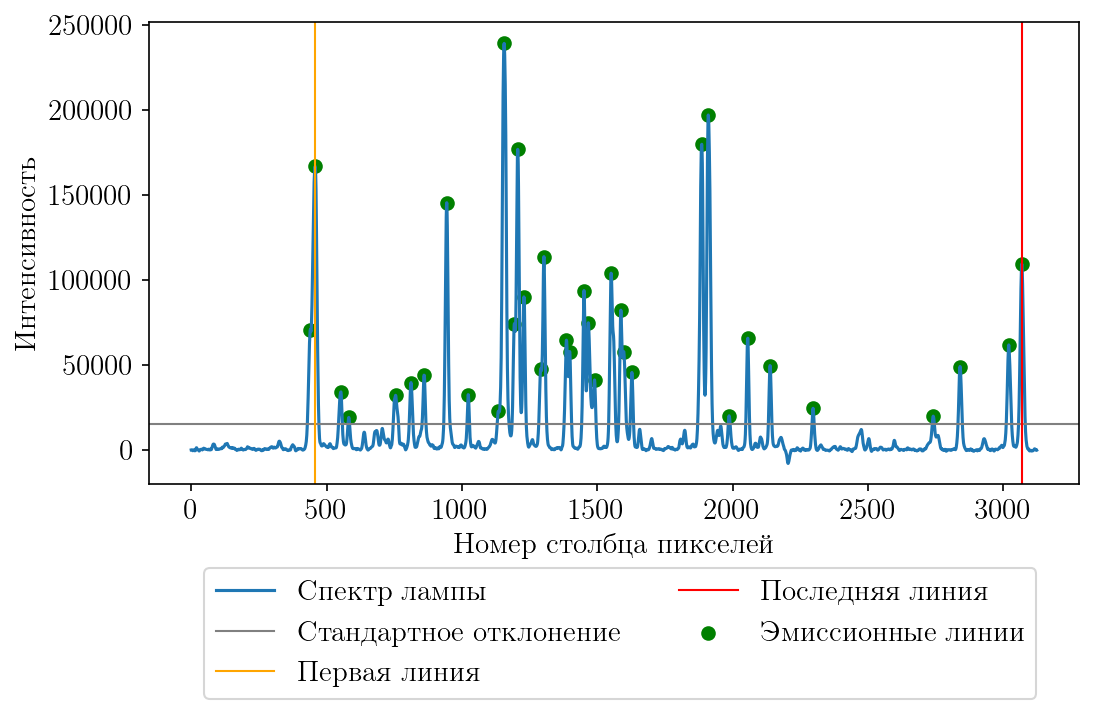

In [363]:
index_1,index_2, index_l1,index_l2= x_axis_to_wavelenght(lamp1,lamp2)

In [358]:
lambd_0 = 4711.2
lambd_n = 5764

In [356]:
np.array(index_l1)

array([ 444,  539,  569,  739,  801,  850,  934, 1015, 1126, 1147, 1185,
       1199, 1222, 1283, 1296, 1379, 1391, 1444, 1461, 1484, 1544, 1580,
       1592, 1622, 1879, 1904, 2049, 2131, 2290, 2730, 2826, 3005, 3051])

In [357]:
np.array(index_l2)

array([ 440,  458,  553,  755,  812,  860,  944, 1023, 1156, 1194, 1206,
       1229, 1291, 1303, 1386, 1398, 1451, 1467, 1490, 1551, 1587, 1597,
       1628, 1886, 1910, 2056, 2138, 2840, 3020, 3068])

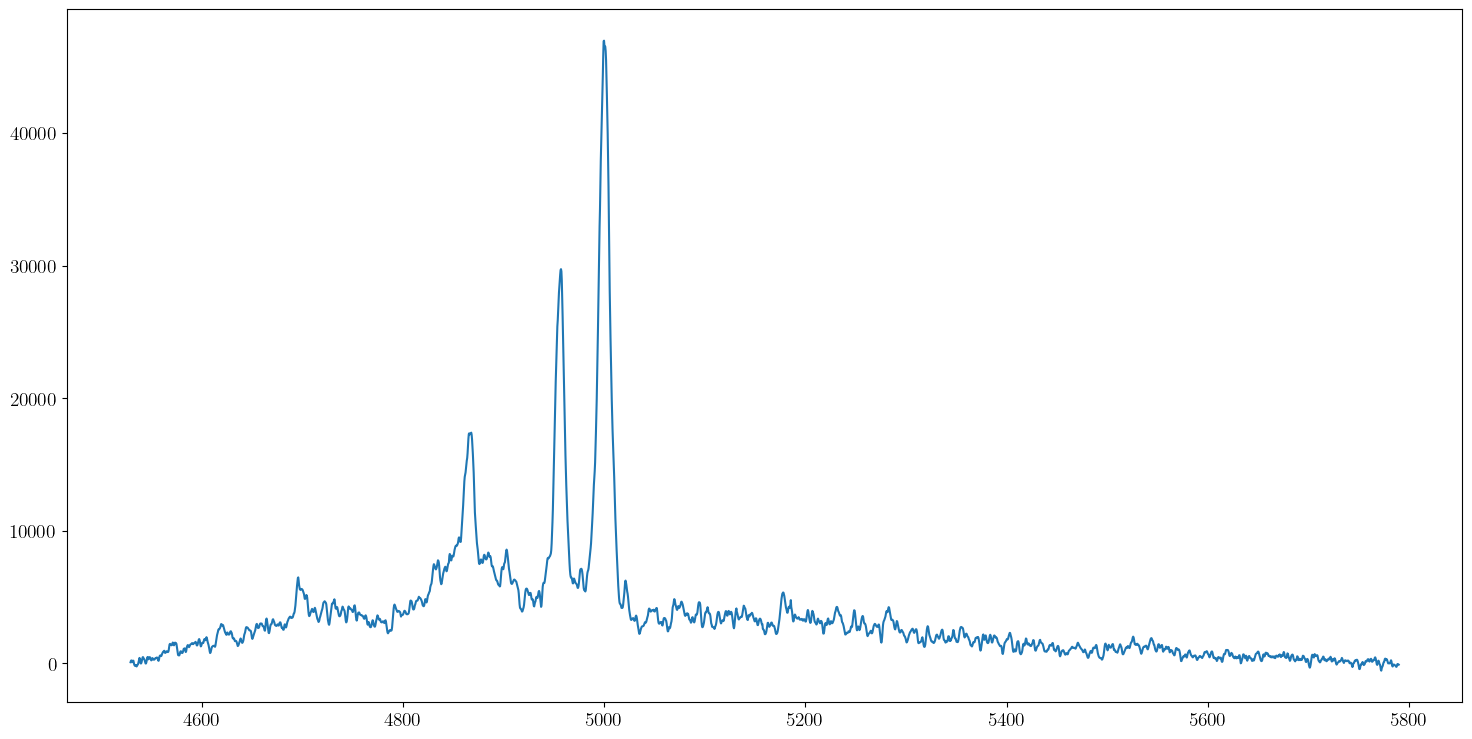

In [359]:
wavelenght,dispersion = pixel2wavelenght(spectra,lambd_0,lambd_n,index_1,index_2)

Text(0, 0.5, 'Интенсивность')

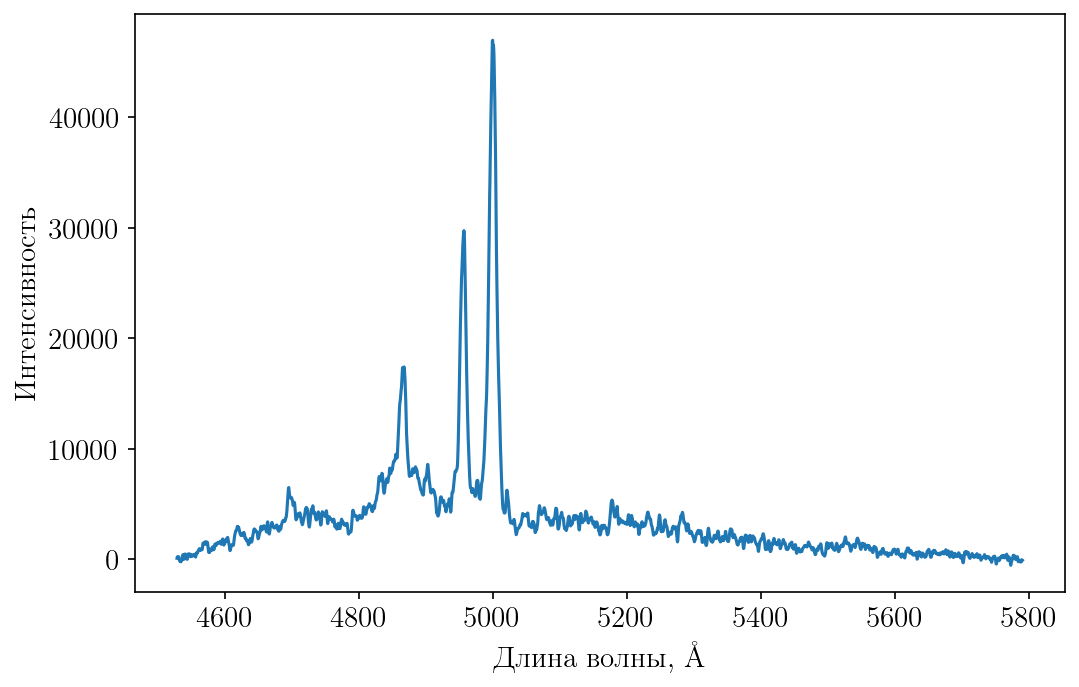

In [387]:
plt.figure(figsize=(8,5),dpi=150)
plt.plot(wavelenght,spectra)
plt.xlabel(r"Длина волны, \AA")
plt.ylabel(r"Интенсивность")

In [366]:
lambd_1 = 4752.73
x1 = 546
lambd_2=4921.93
x2=939
lambd_3=5015.7
x3=1152
lambd_4=5433.65
x4=2134
lambd_5=5681
x5=2833


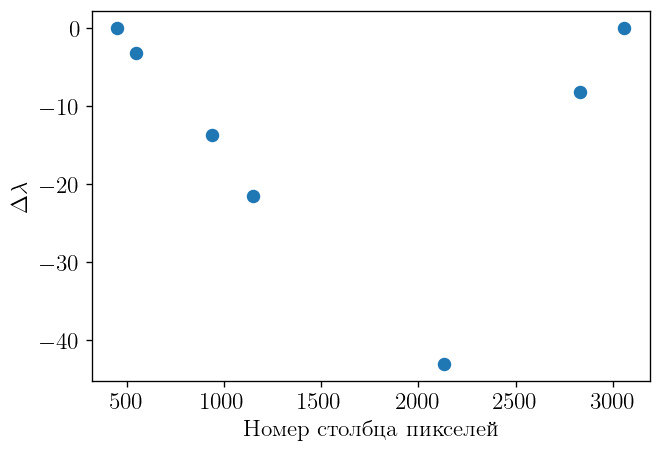

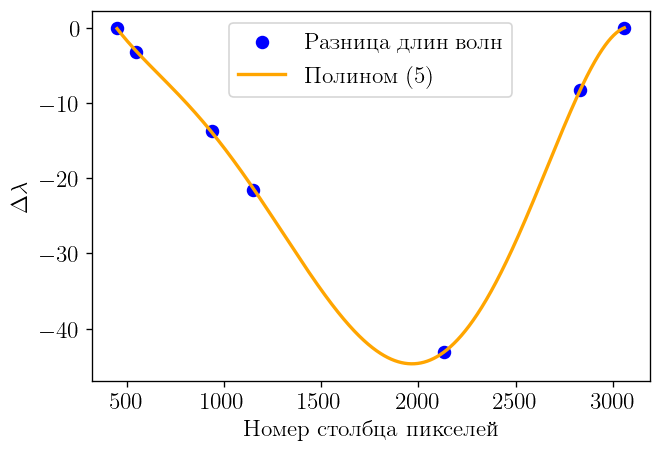

In [389]:
wavelenght_corrected,polinomial = func(index_1,index_2,x1,x2,x3,x4,x5,lambd_1,lambd_2,lambd_3,lambd_4,lambd_5,wavelenght)

In [401]:
import translators

ModuleNotFoundError: No module named 'translators'

In [400]:
transliterate.translit("вапкмв",language_code="ru",reversed=True)

'vapkmv'

Text(0, 0.5, 'Интенсивность')

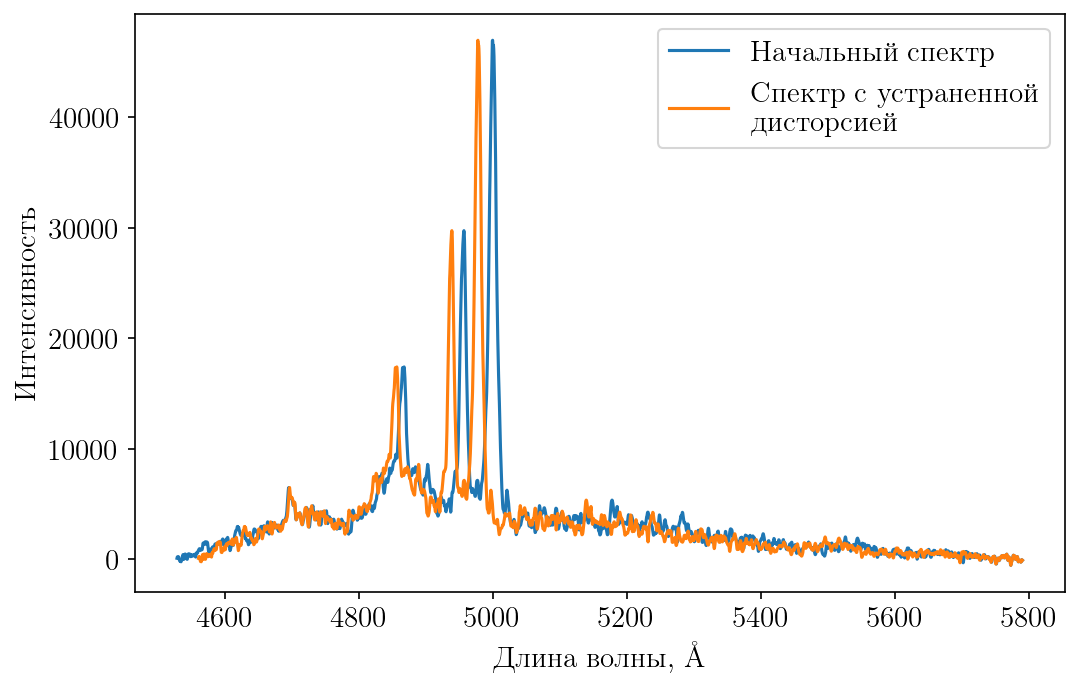

In [392]:
plt.figure(figsize=(8,5),dpi=150)
plt.plot(wavelenght,spectra,label="Начальный спектр")
plt.plot(wavelenght_corrected,spectra,label="Спектр с устраненной \nдисторсией")
plt.legend()
plt.xlabel(r"Длина волны, \AA")
plt.ylabel(r"Интенсивность")